# Energy A.I. Hackathon 2026 Workflow - Energ-AI-z

#### Authors: 
Abraham Montes, Department of Petroleum Engineering<br>
Chris Lopez, Department of Aerospace Engineering<br>
Dalma Cerro, Department of Petroleum Engineering<br>
Joao Brandao, Cockrell School of Engineering<br>
Simón Montoya-Bedoya, Department of Mechanical Engineering


#### The University of Texas at Austin, Austin, Texas, USA 
___

### Executive Summary 

1. What is the problem?
Build a calibrated model that predicts the 3-year cumulative oil production from well-bore log data. ​

2. How did we approach the problem?
We developed a machine learning workflow to build the best possible model to predict the accumulated oil production at the end of the 1st three years incorporating knowledge about petrophysics and petroleum engineering

3. What did we learn?
We learnt that effect of pressure depletion on the reservoir is highly impactful (the effect is very crisp) to accurate forecast the oil production.
We learnt the importance of considering reservoir connectivity, the ffect of parent-children well interactions, distance between well, facies distribution (relation of permeability and porosity is highly relevant) along the wellbore.

4. What do we recommend going forward?
We recommend to evaluate the spatial distribution of facies in the reservoir to locate new wells.

For forecasting: We recommend to reconstruct a forecasting model every certain amount of time based on how pressure depletion affects the relationship between the variables and the cummulative oil production.

___

### Workflow Goal

To identify the best predictors of production, to construct a prediction model, to forecast the oil production for wells 72-83.
___

### Workflow Steps 
Enumerated steps, very short and concise overview of your methods and workflow

1. **Data Analysis** - basic data checking and visualization
2. **Feature Selection** - mutual information-based approach with minimum redundancy, maximum relevance score
3. **Machine Learning Model \#1** - Predict feature $X$ from $Y,Z$

$\ldots$


In [46]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sb
from scipy.stats import kurtosis, skew, spearmanr
from scipy.linalg import norm, lstsq
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
from scipy.stats import mode

We start our workflow by loading the historical production data to get insights about its behavior 

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/3304098284.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/3304098284.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/3304098284.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476

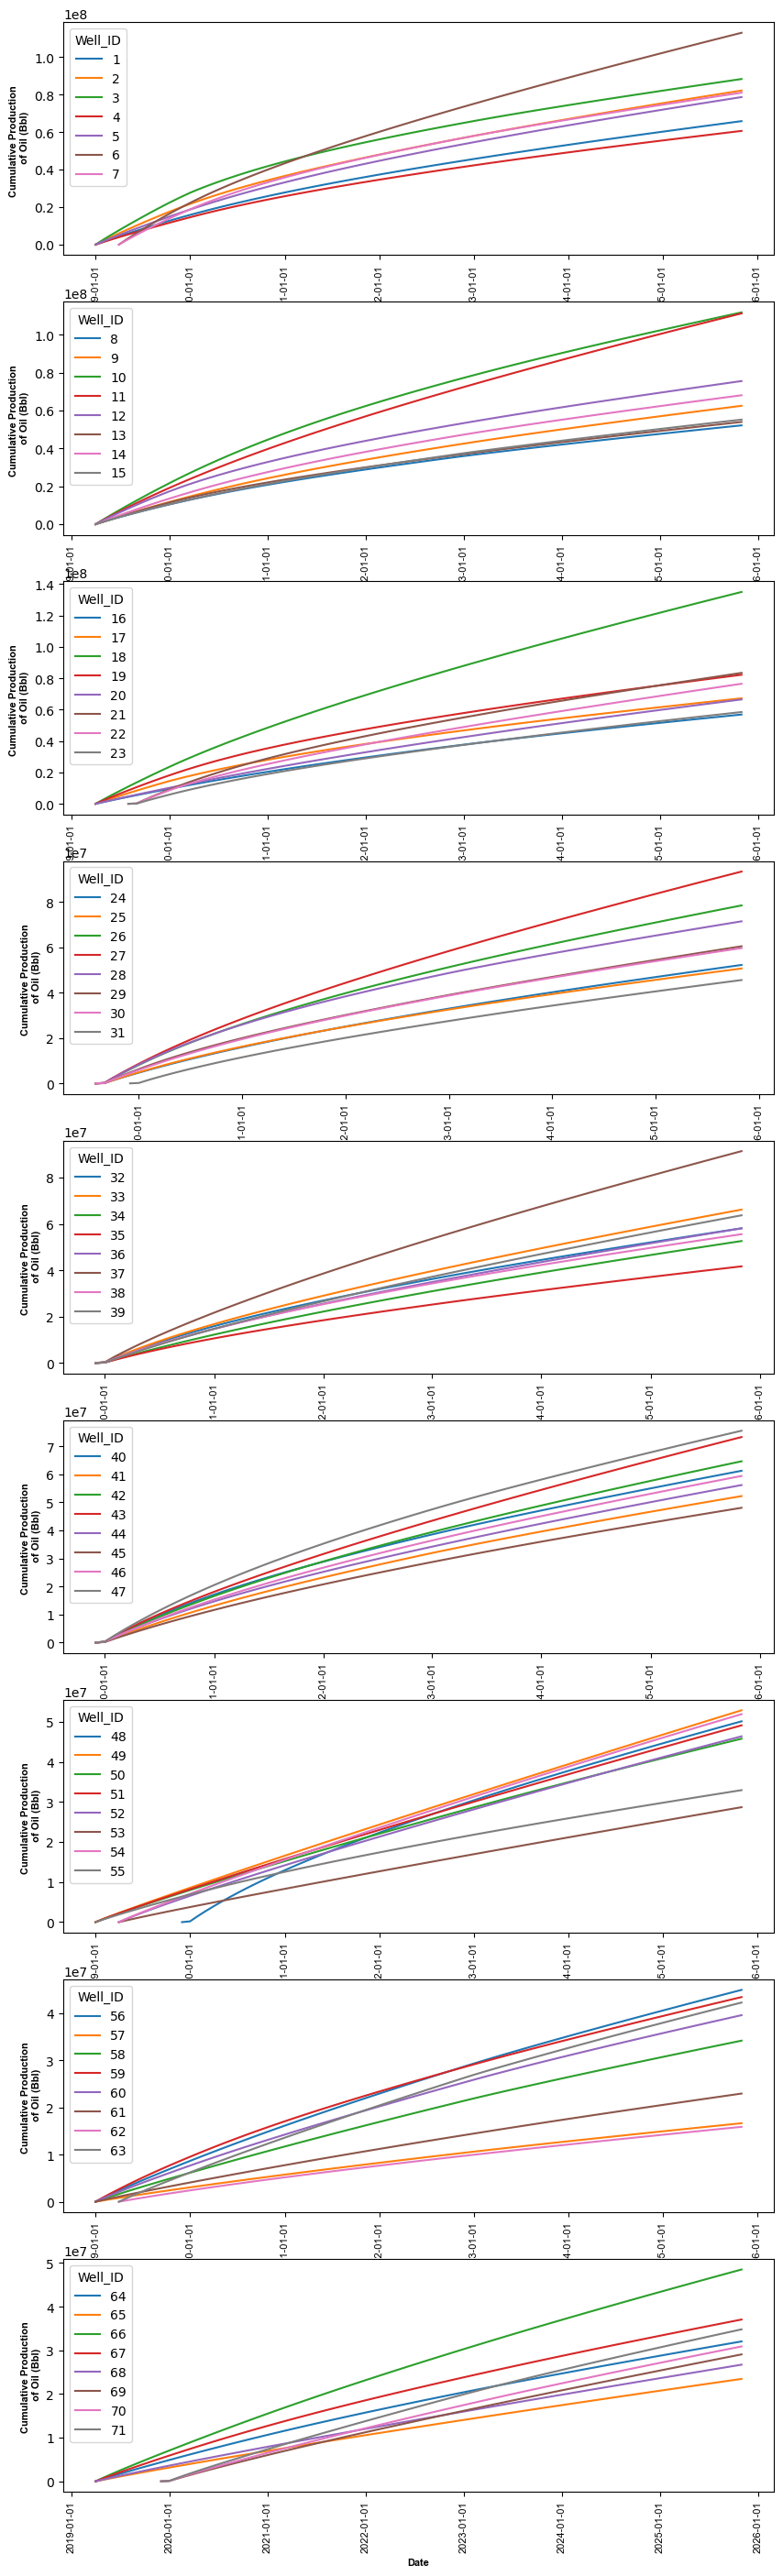

In [47]:
# Defining dataset to train our models and do our predictions
# Definig dataframe to work with
historic_production_data = pd.read_csv( "production.csv",parse_dates=["Date"] )
fig,ax = plt.subplots( 9,1,figsize=(10,35) )

# Plotting cumulative production for some wells
for i in range(9):
    wellidx     = i*8
    sb.lineplot( data=historic_production_data[(historic_production_data["Well_ID"]>=wellidx) & (historic_production_data["Well_ID"]<=wellidx+7)], x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax[i] )
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [48]:
# Observing unique well ids in the dataset
np.unique(historic_production_data["Well_ID"])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71])

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/117343385.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8})


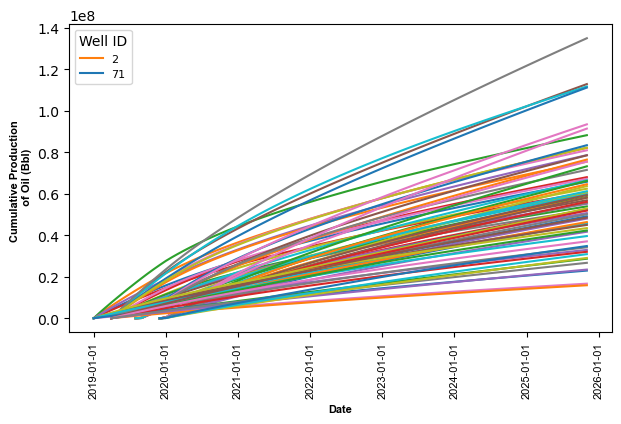

In [49]:
# Stuyding the cumulative production for all wells in a single plot
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=historic_production_data, x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8})
# Put just legend for 1st and last well
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=[handles[1],handles[-1]], labels=[labels[1],labels[-1]], title="Well ID",title_fontsize=10,fontsize=8 )

In [50]:
# Defining features to work with
dflogs = pd.read_csv("logs.csv")

#dflogs_imp = pd.read_csv("well_log_production_imputed_subset.csv")

# Concat dflogs with dflogs_imp to fill missing values
#dflogs = pd.concat( [dflogs,dflogs_imp],axis=0 )
 
# Creating empty columns to fill with features calculated from well logs
historic_production_data["gamma_var"] = 0
historic_production_data["gamma_skew"] = 0
historic_production_data["months"] = 0
historic_production_data["mean_por"] = 0
historic_production_data["mean_perm"] = 0
historic_production_data["kurt_perm"] = 0
historic_production_data["neighbor_density_25"] = 0
historic_production_data["neighbor_density_70"] = 0
historic_production_data["X"] = 0
historic_production_data["Y"] = 0
historic_production_data["cumulative_3y"] = 0
historic_production_data["gamma_mean"] = 0
historic_production_data["facies_p75"] = 0
historic_production_data["z_mean"] = 0
historic_production_data["acoustic_imp"] = 0
historic_production_data["kophi_sqrt_of_means"] = 0
historic_production_data["kophi_mean_of_sqrts"] = 0

def calculate_well_density( xvals,yvals,allx,ally,allIDs,quantile ):
    x   = xvals[0]
    y   = yvals[0]
    ids = np.unique( allIDs )
    dists = [  ]
    for id in ids:
        idxs=np.argwhere( allIDs==id )
        xs  = allx[idxs][0]
        ys  = ally[idxs][0]
        if x!=xs and y!=ys:
            dists.append( 1/norm( np.array([x-xs,y-ys]) ) )
    return np.min( dists )

for id in np.unique(dflogs["Well_ID"]):
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"X"] = np.unique( dflogs[dflogs["Well_ID"]==id]["X"] )[0]
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"Y"] = np.unique( dflogs[dflogs["Well_ID"]==id]["Y"] )[0]
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"kophi_mean_of_sqrts"] = ( np.mean( np.sqrt(dflogs[dflogs["Well_ID"]==id]["perm"]/dflogs[dflogs["Well_ID"]==id]["phi"] ) ) )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"z_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["Z"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"gamma_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["GR"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"facies_p75"] = np.quantile( dflogs[dflogs["Well_ID"]==id]["facies"],0.75 )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"gamma_skew"] = skew( dflogs[dflogs["Well_ID"]==id]["GR"].values )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"mean_por"] = np.mean( dflogs[dflogs["Well_ID"]==id]["phi"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"mean_perm"] = np.mean( dflogs[dflogs["Well_ID"]==id]["perm"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"kurt_perm"] = kurtosis( dflogs[dflogs["Well_ID"]==id]["perm"].values )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"neighbor_density_25"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.25 )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"neighbor_density_70"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.7 )
    historic_production_data.loc[historic_production_data["Well_ID"] == id, "months"] = (
        historic_production_data.loc[historic_production_data["Well_ID"] == id, "Date"]
        - historic_production_data.loc[historic_production_data["Well_ID"] == id, "Date"].min(  )
    ).dt.days
    monthsWell          = historic_production_data[historic_production_data["Well_ID"]==id]["months"] - 36
    prodWell          = historic_production_data[historic_production_data["Well_ID"]==id]["Cumulative Oil Production, BBL"]
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"cumulative_3y"] = np.min( prodWell[monthsWell>0] )
    
historic_production_data["months"]=historic_production_data["months"]/30

# Getting a feeling og the dataset with new features
historic_production_data

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/2213352090.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.61655934299265' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  historic_production_data.loc[historic_production_data["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/2213352090.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5096851.315789473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  historic_production_data.loc[historic_production_data["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI"] )
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/2213352090.py:46: FutureWarning

Well_ID       Date  Cumulative Gas Production, ft3  \
0           1 2019-01-01                    0.000000e+00   
1           1 2019-02-01                    1.981249e+09   
2           1 2019-03-01                    3.661006e+09   
3           1 2019-04-01                    5.474707e+09   
4           1 2019-05-01                    7.194637e+09   
...       ...        ...                             ...   
5512       71 2025-07-01                    4.209285e+10   
5513       71 2025-08-01                    4.262622e+10   
5514       71 2025-09-01                    4.315820e+10   
5515       71 2025-10-01                    4.367173e+10   
5516       71 2025-11-01                    4.420112e+10   

      Cumulative Oil Production, BBL  Cumulative Water Production, BBL  \
0                               0.00                      0.000000e+00   
1                         1560038.50                      4.634771e+04   
2                         2882681.25                      8.738335e+04   
3                         4310793.00                      1.334990e+05   
4                         5665069.00                      1.791346e+05   
...                              ...                               ...   
5512                     33143974.00                      2.761039e+06   
5513                     33563956.00                      2.809077e+06   
5514                     33982832.00                      2.857320e+06   
5515                     34387188.00                      2.904204e+06   
5516                     34804032.00                      2.952848e+06   

      gamma_var  gamma_skew     months  mean_por   mean_perm  ...  \
0     12.616559         NaN   0.000000  0.225434  884.329315  ...   
1     12.616559         NaN   1.033333  0.225434  884.329315  ...   
2     12.616559         NaN   1.966667  0.225434  884.329315  ...   
3     12.616559         NaN   3.000000  0.225434  884.329315  ...   
4     12.616559         NaN   4.000000  0.225434  884.329315  ...   
...         ...         ...        ...       ...         ...  ...   
5512  27.173784    0.225046  67.966667  0.176152  429.657251  ...   
5513  27.173784    0.225046  69.000000  0.176152  429.657251  ...   
5514  27.173784    0.225046  70.033333  0.176152  429.657251  ...   
5515  27.173784    0.225046  71.033333  0.176152  429.657251  ...   
5516  27.173784    0.225046  72.066667  0.176152  429.657251  ...   

      neighbor_density_70    X    Y  cumulative_3y  gamma_mean  facies_p75  \
0                0.005692   33  127     2882681.25    34.50313         NaN   
1                0.005692   33  127     2882681.25    34.50313         NaN   
2                0.005692   33  127     2882681.25    34.50313         NaN   
3                0.005692   33  127     2882681.25    34.50313         NaN   
4                0.005692   33  127     2882681.25    34.50313         NaN   
...                   ...  ...  ...            ...         ...         ...   
5512             0.005708  151  166      812823.00    58.07322         5.0   
5513             0.005708  151  166      812823.00    58.07322         5.0   
5514             0.005708  151  166      812823.00    58.07322         5.0   
5515             0.005708  151  166      812823.00    58.07322         5.0   
5516             0.005708  151  166      812823.00    58.07322         5.0   

      z_mean  acoustic_imp  kophi_sqrt_of_means  kophi_mean_of_sqrts  
0         29  5.096851e+06                    0            54.702954  
1         29  5.096851e+06                    0            54.702954  
2         29  5.096851e+06                    0            54.702954  
3         29  5.096851e+06                    0            54.702954  
4         29  5.096851e+06                    0            54.702954  
...      ...           ...                  ...                  ...  
5512      29  6.083808e+06                    0            42.329698  
5513      29  6.083808e+06                    0            42.

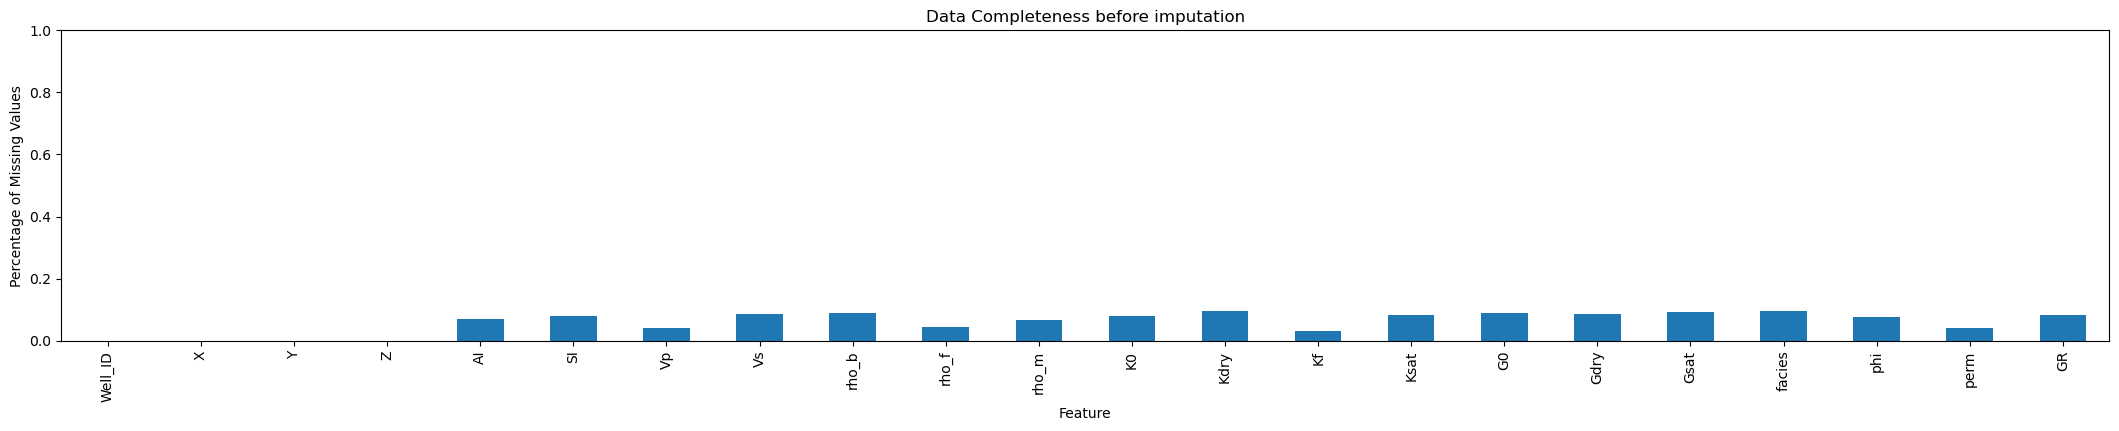

In [51]:
# Let's take a look to the data before and after imputing missing values
# Plotting data completeness before and after imputation
plt.subplot(311)
(dflogs.isnull().sum()/len(dflogs)).plot(kind = 'bar')          # calculate DataFrame with percentage missing by feature
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness before imputation'); plt.ylim([0.0,1.0])
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

# For imputationed data
# plt.subplot(311)
# (dflogs_imp.isnull().sum()/len(dflogs_imp)).plot(kind = 'bar')          # calculate DataFrame with percentage missing by feature
# plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness after imputation'); plt.ylim([0.0,1.0])
# plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
# plt.show()

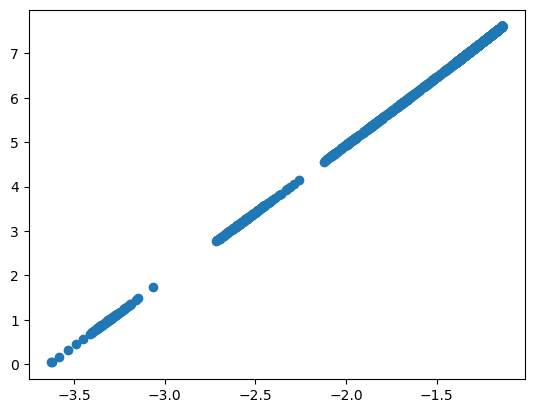

In [52]:
# Exploring the relationship between porosity and permeability
plt.scatter( np.log( dflogs["phi"] ),np.log(dflogs["perm"]) )

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/3821693220.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


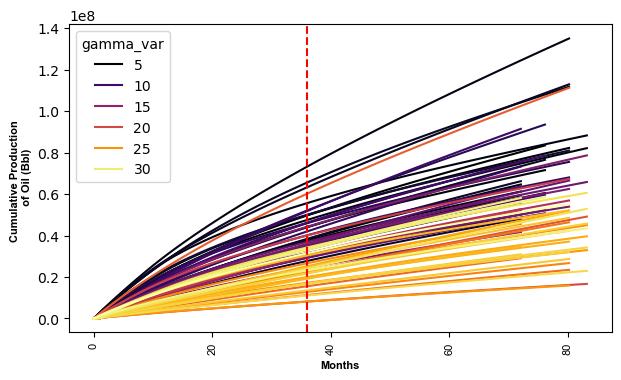

In [53]:
# Exploring the relationship of the cumulative production with gamma ray variance
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=historic_production_data, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_var",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/3150424080.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


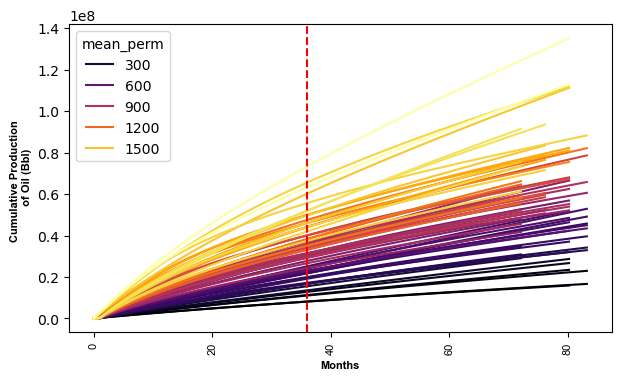

In [54]:
# Exploring the relationship of the cumulative production with gamma ray variance
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=historic_production_data, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_perm",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/1747015170.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


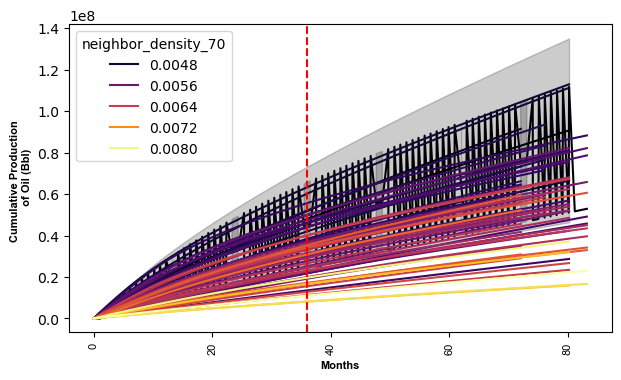

In [55]:
# Exploring the relationship of the cumulative production with neighbor density
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=historic_production_data, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="neighbor_density_70",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

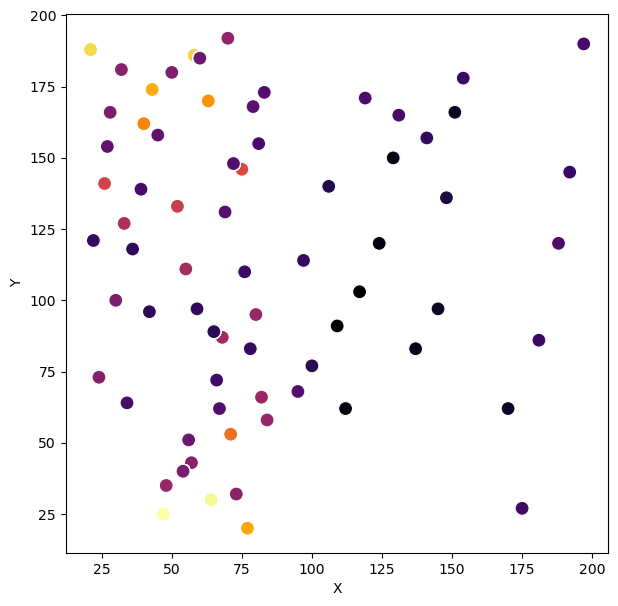

In [56]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=historic_production_data,x="X",y="Y",hue="cumulative_3y",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

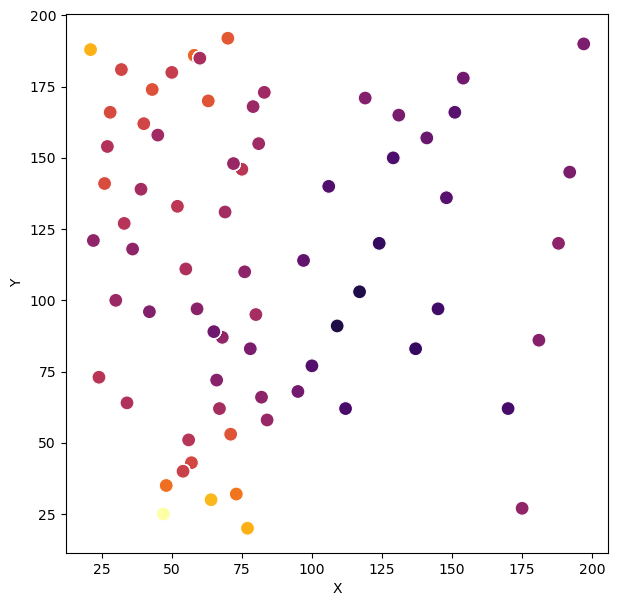

In [57]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=historic_production_data,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

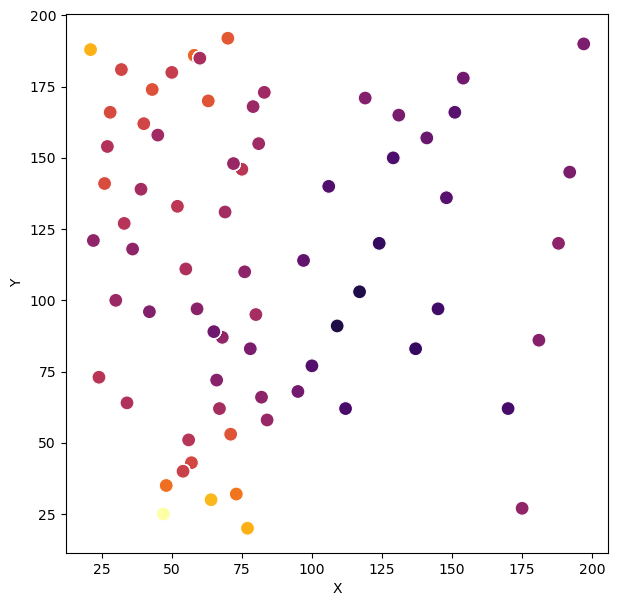

In [58]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=historic_production_data,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

In [59]:
# Extracting first value from unique well IDs since we will it out with features already calculated
df_out = historic_production_data.groupby("Well_ID", as_index=False).first( )
df_out.head(  )

Well_ID       Date  Cumulative Gas Production, ft3  \
0        1 2019-01-01                             0.0   
1        2 2019-01-01                             0.0   
2        3 2019-01-01                             0.0   
3        4 2019-01-01                             0.0   
4        5 2019-01-01                             0.0   

   Cumulative Oil Production, BBL  Cumulative Water Production, BBL  \
0                             0.0                               0.0   
1                             0.0                               0.0   
2                             0.0                               0.0   
3                             0.0                               0.0   
4                             0.0                               0.0   

   gamma_var  gamma_skew  months  mean_por    mean_perm  ...  \
0  12.616559         NaN     0.0  0.225434   884.329315  ...   
1   5.077962         NaN     0.0  0.267459  1234.271081  ...   
2   5.404112         NaN     0.0  0.291969  1555.899331  ...   
3  29.342676         NaN     0.0  0.199860   795.671897  ...   
4  14.133232    0.909802     0.0  0.248035  1026.938746  ...   

   neighbor_density_70   X    Y  cumulative_3y  gamma_mean  facies_p75  \
0             0.005692  33  127     2882681.25   34.503130         NaN   
1             0.005373  71   53     3972052.50   28.114431         NaN   
2             0.005066  58  186     5067011.00   26.777932         NaN   
3             0.006635  80   95     2633379.50   44.726999         NaN   
4             0.005330  26  141     3362580.50   31.695926         NaN   

   z_mean  acoustic_imp  kophi_sqrt_of_means  kophi_mean_of_sqrts  
0      29  5.096851e+06                    0            54.702954  
1      29  4.385331e+06                    0            65.265503  
2      29  3.972625e+06                    0            71.665218  
3      29  5.358182e+06                    0            48.476151  
4      29  4.696387e+06                    0            60.406244  

[5 rows x 22 columns]

In [60]:
# Extracting all property names from the dataframe
# Need to delete unnecesary columns
propertiesNames = df_out.columns.tolist()


df_out = df_out[["gamma_var","gamma_mean","mean_por","mean_perm","neighbor_density_25","neighbor_density_70","facies_p75","Y","X","acoustic_imp","kophi_mean_of_sqrts","Well_ID","cumulative_3y"]]

df_out.head(  )

gamma_var  gamma_mean  mean_por    mean_perm  neighbor_density_25  \
0  12.616559   34.503130  0.225434   884.329315             0.005692   
1   5.077962   28.114431  0.267459  1234.271081             0.005373   
2   5.404112   26.777932  0.291969  1555.899331             0.005066   
3  29.342676   44.726999  0.199860   795.671897             0.006635   
4  14.133232   31.695926  0.248035  1026.938746             0.005330   

   neighbor_density_70  facies_p75    Y   X  acoustic_imp  \
0             0.005692         NaN  127  33  5.096851e+06   
1             0.005373         NaN   53  71  4.385331e+06   
2             0.005066         NaN  186  58  3.972625e+06   
3             0.006635         NaN   95  80  5.358182e+06   
4             0.005330         NaN  141  26  4.696387e+06   

   kophi_mean_of_sqrts  Well_ID  cumulative_3y  
0            54.702954        1     2882681.25  
1            65.265503        2     3972052.50  
2            71.665218        3     5067011.00  
3            48.476151        4     2633379.50  
4            60.406244        5     3362580.50

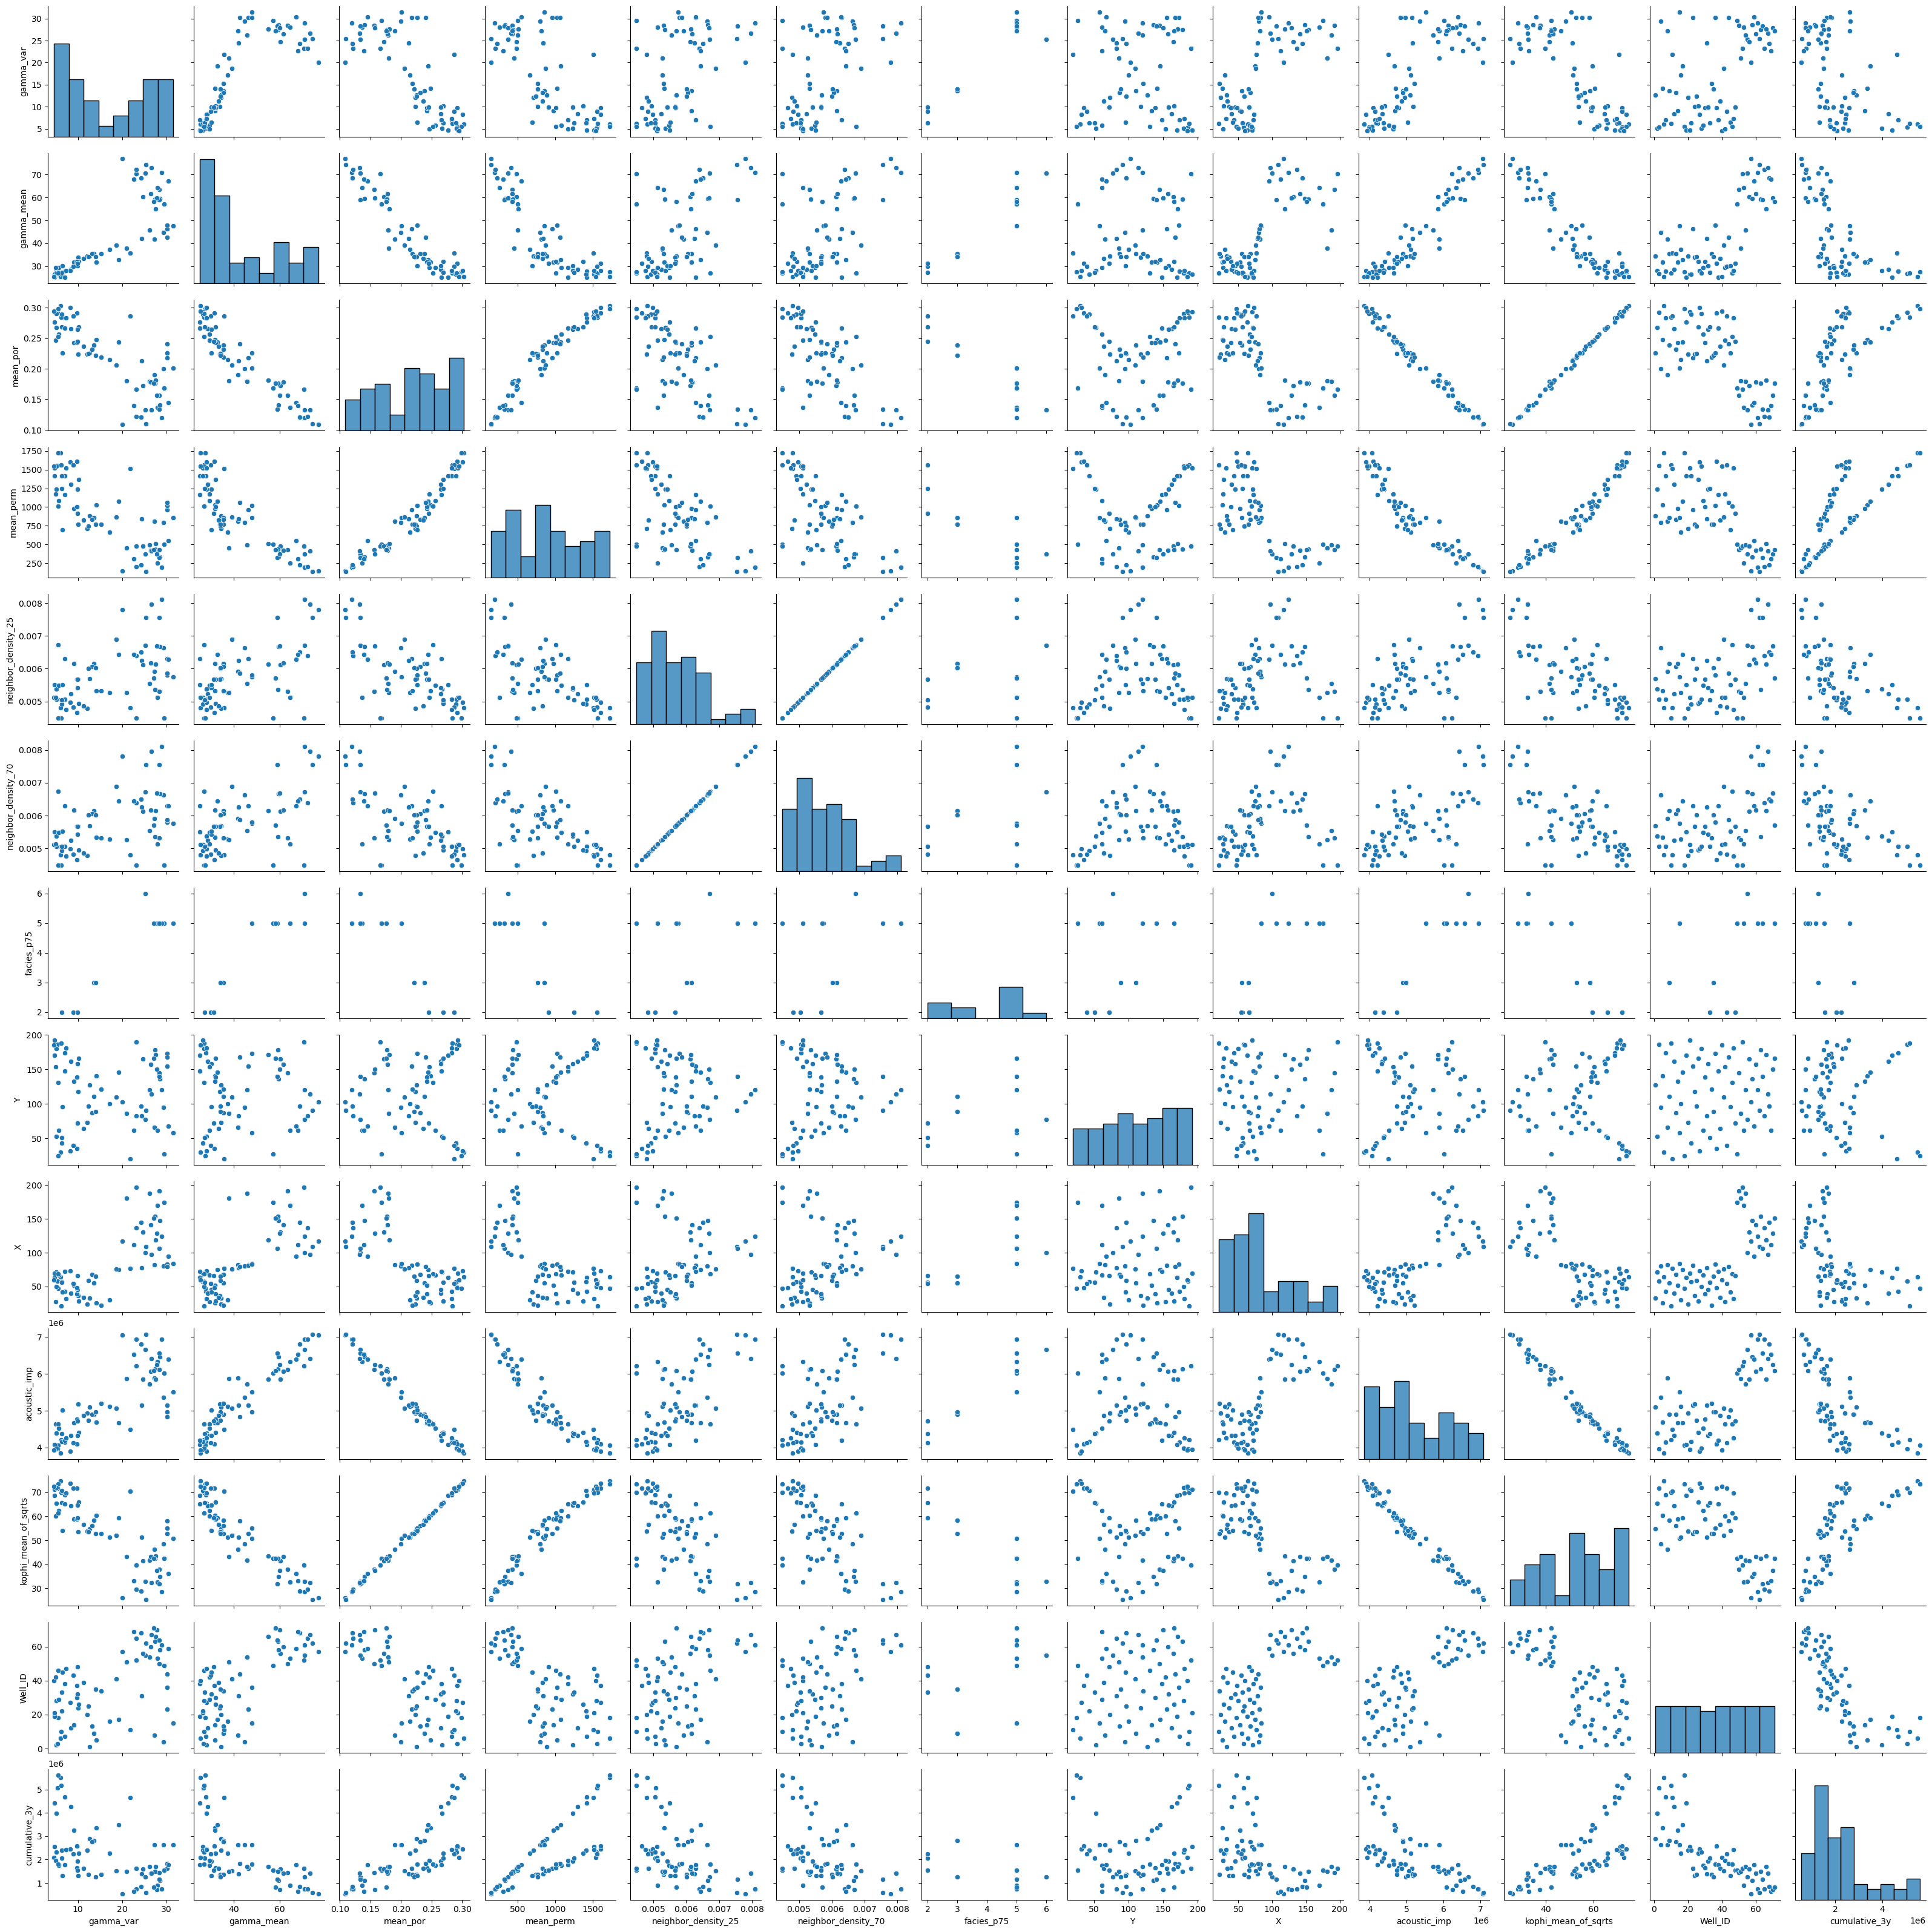

In [61]:
sb.pairplot(df_out)

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

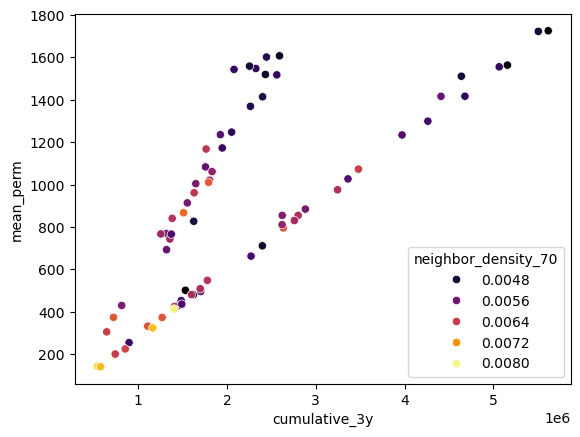

In [62]:
df_out["is_crowded"] = np.where(df_out["neighbor_density_70"]>0.006,1,0)
# sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="is_crowded",palette="inferno" )
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="neighbor_density_70",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

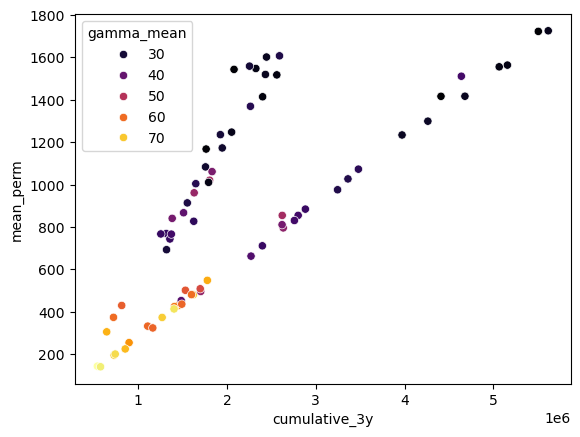

In [63]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="gamma_mean",palette="inferno" )

In [64]:
# Inlcuding other features calculated related to facies and mechanical properties
df_mechanical = pd.read_csv("mechanical.csv" )
df_facies = pd.read_csv("facies.csv")
df_times = pd.read_csv( "times.csv",parse_dates=["earliest"] )

# Facies-related features
df_out["facies_percentage"] = df_facies["Percentage_Facies_3_or_Less"]

# Mechanical properties-related features
df_out["brittleness"] = df_mechanical["Mean_Brittleness_Index"]
df_out["young"] = df_mechanical["Mean_Youngs_Modulus_Velocities"]
df_out["poisson"] = df_mechanical["Mean_Poisson_Ratio_Velocities"]

# Calculating other features to explore their relationship with cumulative production
df_out["porosity_permeability"] = df_out["mean_por"]/df_out["mean_perm"]
df_out["porosity_times_permeability"] = df_out["mean_por"]
# Permeability considering percentage of sands
df_out["perm_over_facies"] = np.where(df_out["facies_percentage"]> 0, df_out["mean_perm"]/df_out["facies_percentage"], 0)

# Using time-related features to see how early or late a well was drilled
df_times["is_before_cutoff_2"] = np.where( df_times["earliest"]<pd.to_datetime( "2019-08-01",format="%Y-%m-%d" ),1,0 )
df_out["well_on"] = np.where(df_times["is_before_cutoff_2"],"early","late")

df_out.head(  )

gamma_var  gamma_mean  mean_por    mean_perm  neighbor_density_25  \
0  12.616559   34.503130  0.225434   884.329315             0.005692   
1   5.077962   28.114431  0.267459  1234.271081             0.005373   
2   5.404112   26.777932  0.291969  1555.899331             0.005066   
3  29.342676   44.726999  0.199860   795.671897             0.006635   
4  14.133232   31.695926  0.248035  1026.938746             0.005330   

   neighbor_density_70  facies_p75    Y   X  acoustic_imp  ...  cumulative_3y  \
0             0.005692         NaN  127  33  5.096851e+06  ...     2882681.25   
1             0.005373         NaN   53  71  4.385331e+06  ...     3972052.50   
2             0.005066         NaN  186  58  3.972625e+06  ...     5067011.00   
3             0.006635         NaN   95  80  5.358182e+06  ...     2633379.50   
4             0.005330         NaN  141  26  4.696387e+06  ...     3362580.50   

   is_crowded  facies_percentage  brittleness     young   poisson  \
0           0          84.210526     0.316659  6.073266  0.360807   
1           0         100.000000     0.295761  5.905293  0.353756   
2           0         100.000000     0.217135  5.829404  0.366579   
3           1          73.684211     0.356151  6.313622  0.368558   
4           0          94.117647     0.321841  6.060783  0.358462   

   porosity_permeability  porosity_times_permeability  perm_over_facies  \
0               0.000255                     0.225434         10.501411   
1               0.000217                     0.267459         12.342711   
2               0.000188                     0.291969         15.558993   
3               0.000251                     0.199860         10.798404   
4               0.000242                     0.248035         10.911224   

   well_on  
0    early  
1    early  
2    early  
3    early  
4    early  

[5 rows x 22 columns]

<Axes: xlabel='mean_perm', ylabel='cumulative_3y'>

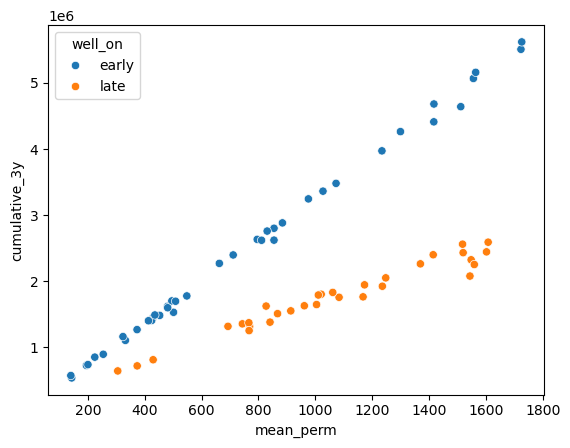

In [65]:
# Plotting cumulative response vs permeability colored by time well was drilled
sb.scatterplot( data=df_out,y="cumulative_3y",x="mean_perm",hue="well_on",palette="tab10" )


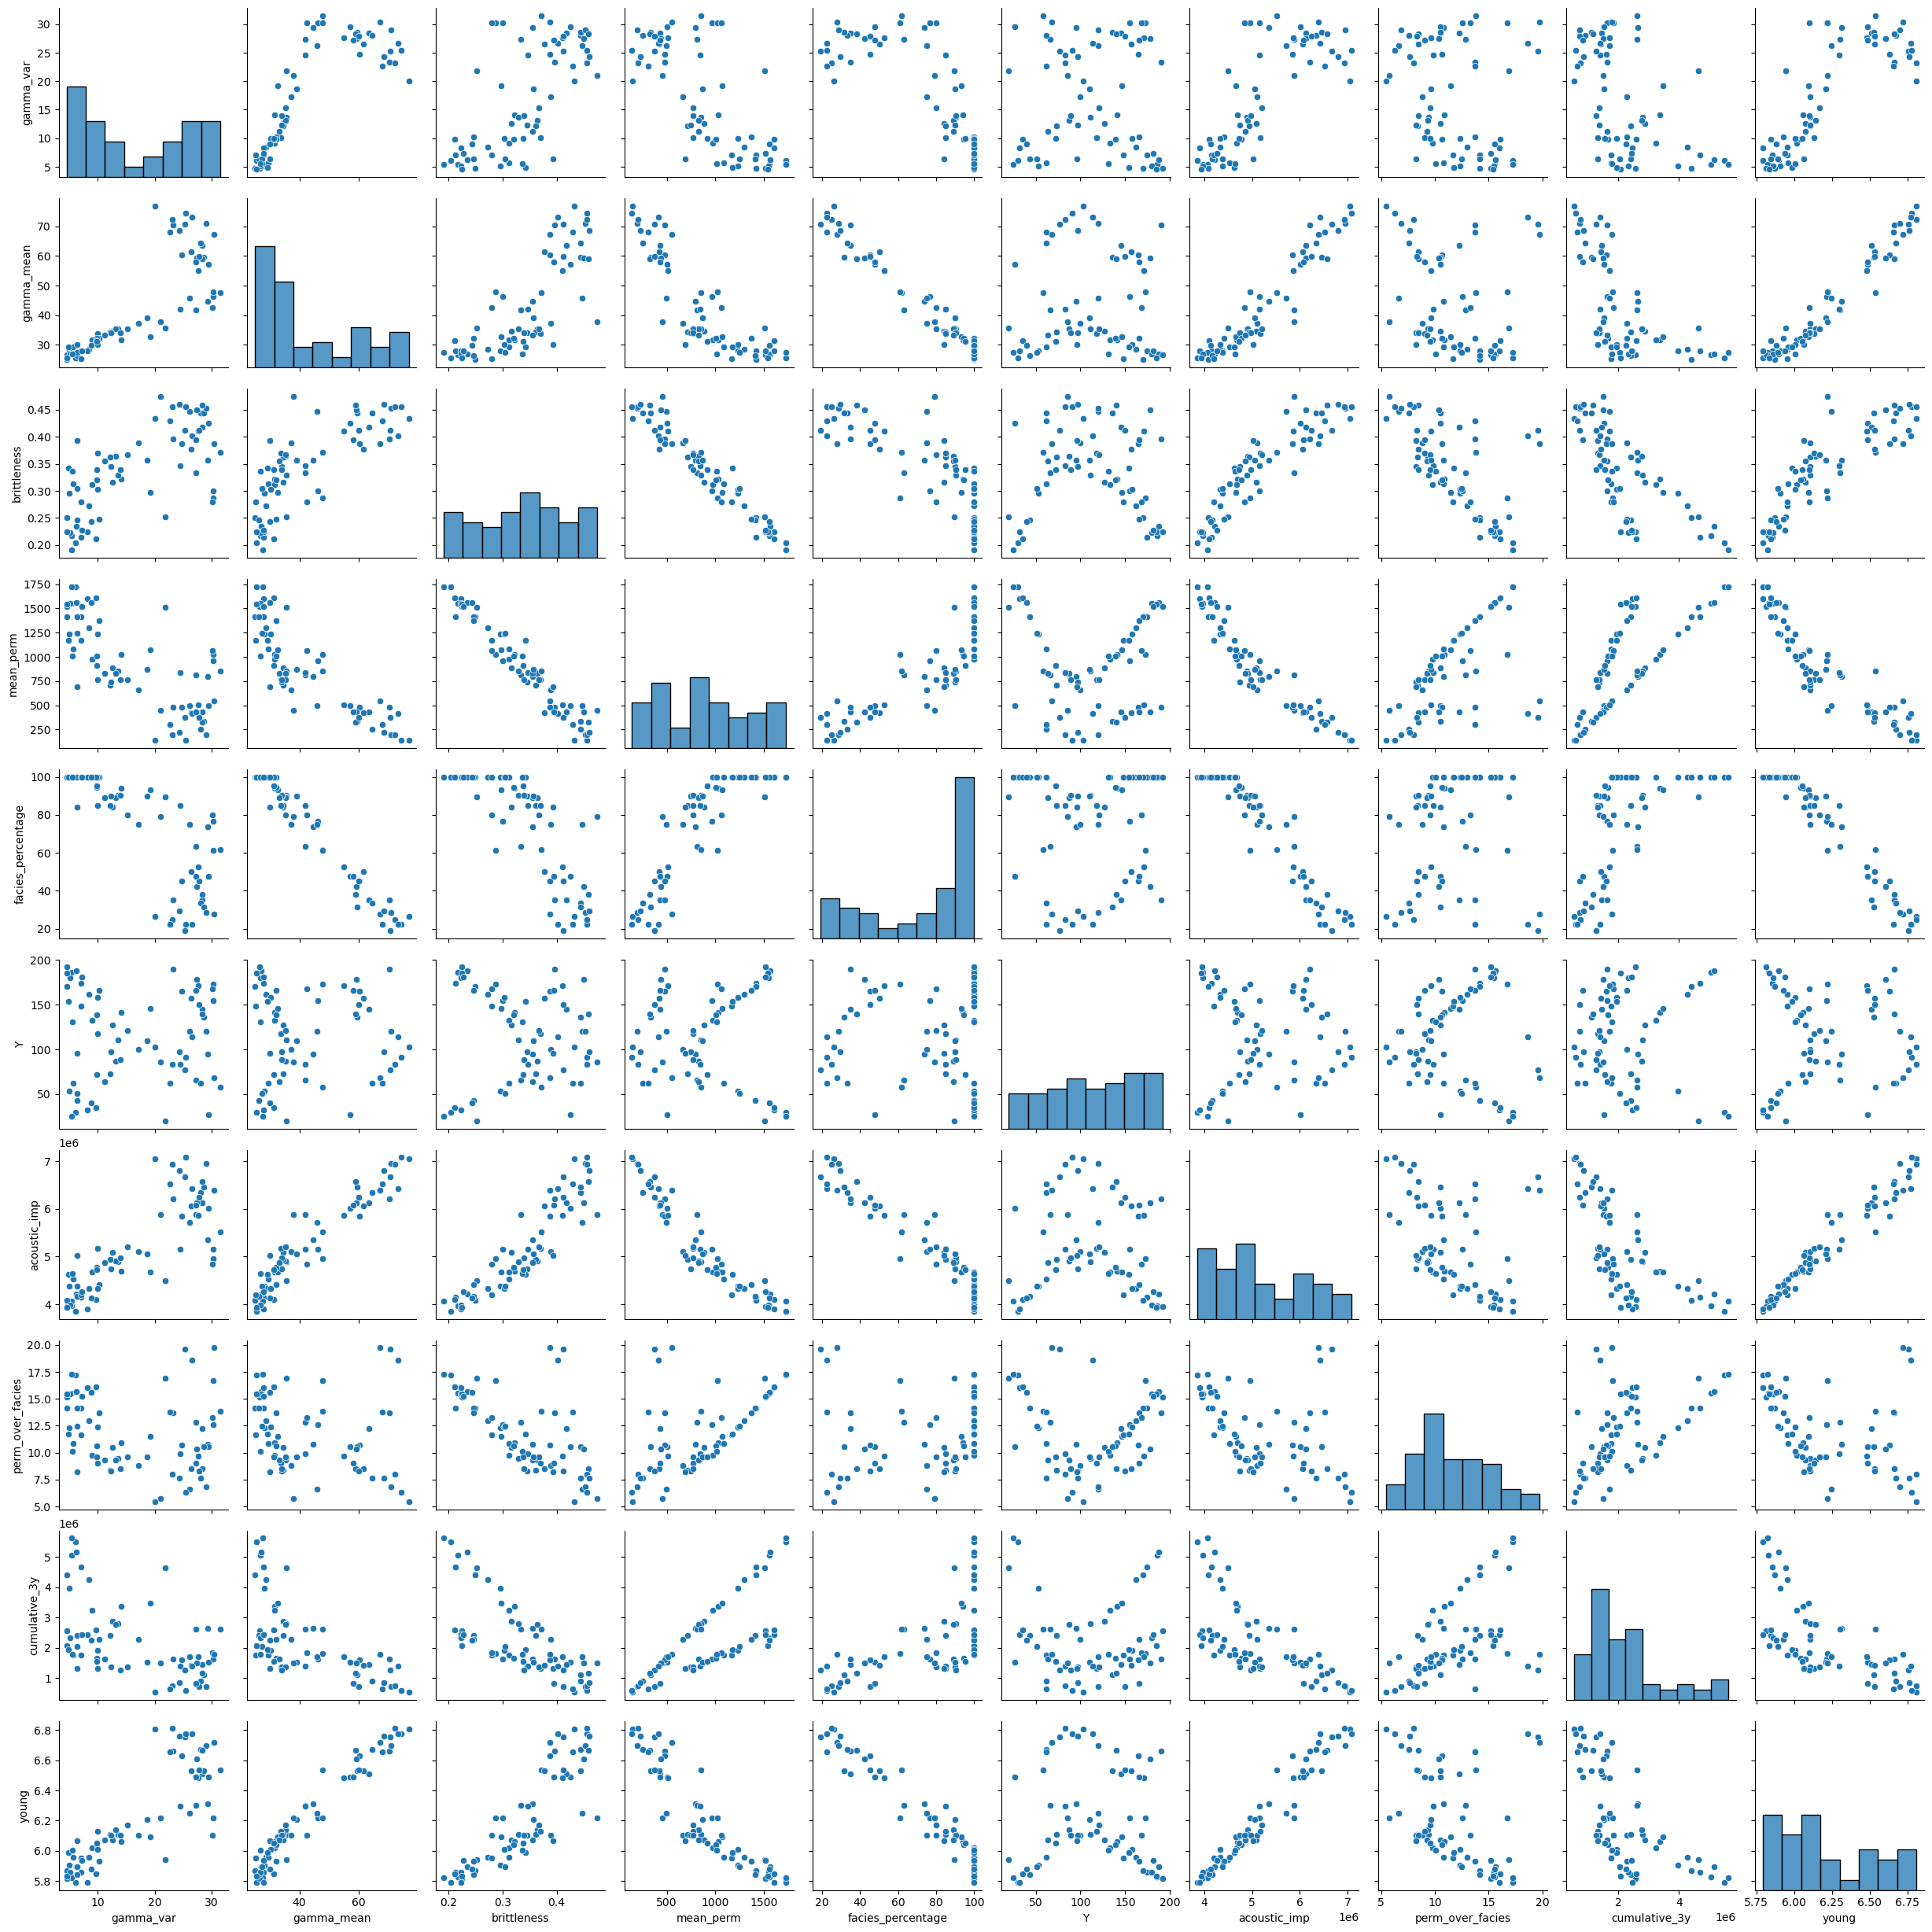

In [66]:
# Testing correlations between features and target against cumulative production using pairplot
df_out = df_out[["gamma_var","gamma_mean","brittleness","mean_perm","facies_percentage","Y","well_on","acoustic_imp","perm_over_facies","cumulative_3y","young"]]

sb.pairplot(df_out)

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

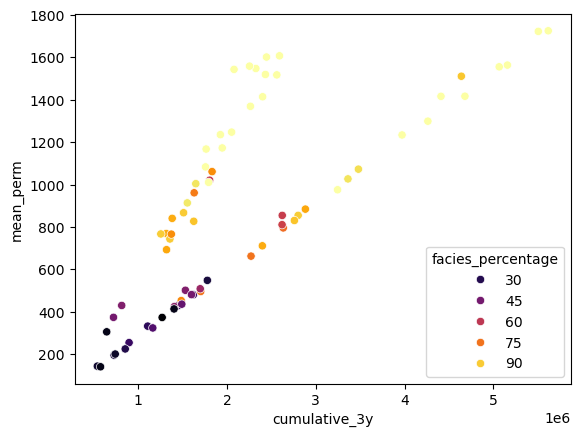

In [67]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="facies_percentage",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

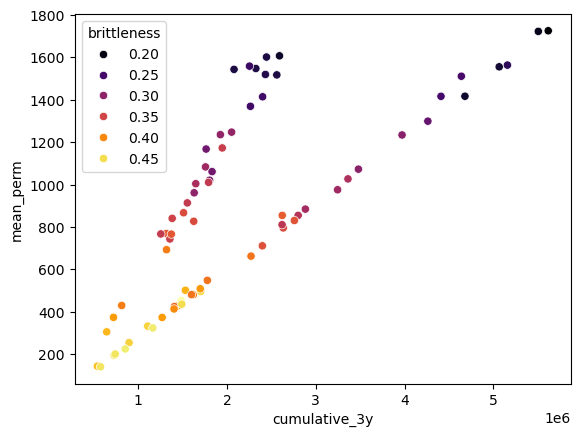

In [68]:
# CReate a scatter plot to see relationship between cumulative production and permeability colored by brittleness with gradient color
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="brittleness",palette="inferno" )

## Training Model with Only Late Wells
Since all the preproduction wells started in 2022 we decided to only utilized the data from late wells for model construction

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/2484556113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/2484556113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["logperm"] = np.log( df_train["mean_perm"] )


<Axes: xlabel='logperm', ylabel='cumulative_3y'>

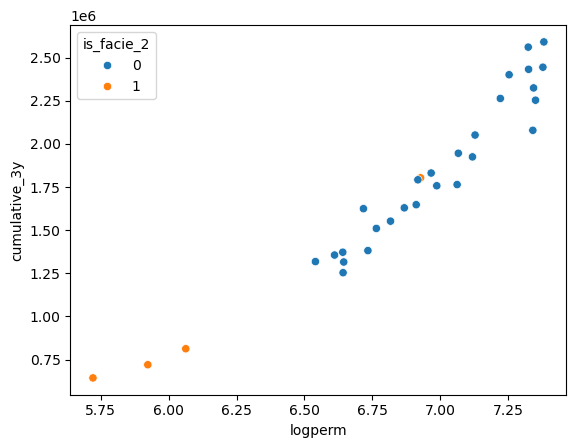

In [69]:
df_train = df_out[df_out["well_on"]=="late"]
df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
df_train["logperm"] = np.log( df_train["mean_perm"] )
sb.scatterplot( data=df_train,x="logperm",y="cumulative_3y",hue="is_facie_2",palette="tab10" )

In [70]:
df_train.head(  )

gamma_var  gamma_mean  brittleness    mean_perm  facies_percentage    Y  \
20   4.665723   26.566998     0.224981  1517.814112         100.000000  192   
21   6.373737   26.424559     0.246787  1414.545568         100.000000   43   
22  30.250608   46.268357     0.300602   961.344992          76.470588  155   
23  10.044680   33.846909     0.369460   769.003251          85.000000  118   
24  12.307833   34.124102     0.344717   743.426858          90.000000   97   

   well_on  acoustic_imp  perm_over_facies  cumulative_3y     young  \
20    late  3.946962e+06         15.178141    2560803.000  5.815694   
21    late  4.169813e+06         14.145456    2400820.250  5.844842   
22    late  5.149280e+06         12.571435    1629373.500  6.216952   
23    late  5.174659e+06          9.047097    1315493.125  6.128699   
24    late  4.739056e+06          8.260298    1355874.875  6.103678   

    is_facie_2   logperm  
20           0  7.325026  
21           0  7.254564  
22           0  6.868333  
23           0  6.645095  
24           0  6.611270

# Model selection
## Polynomial regression model

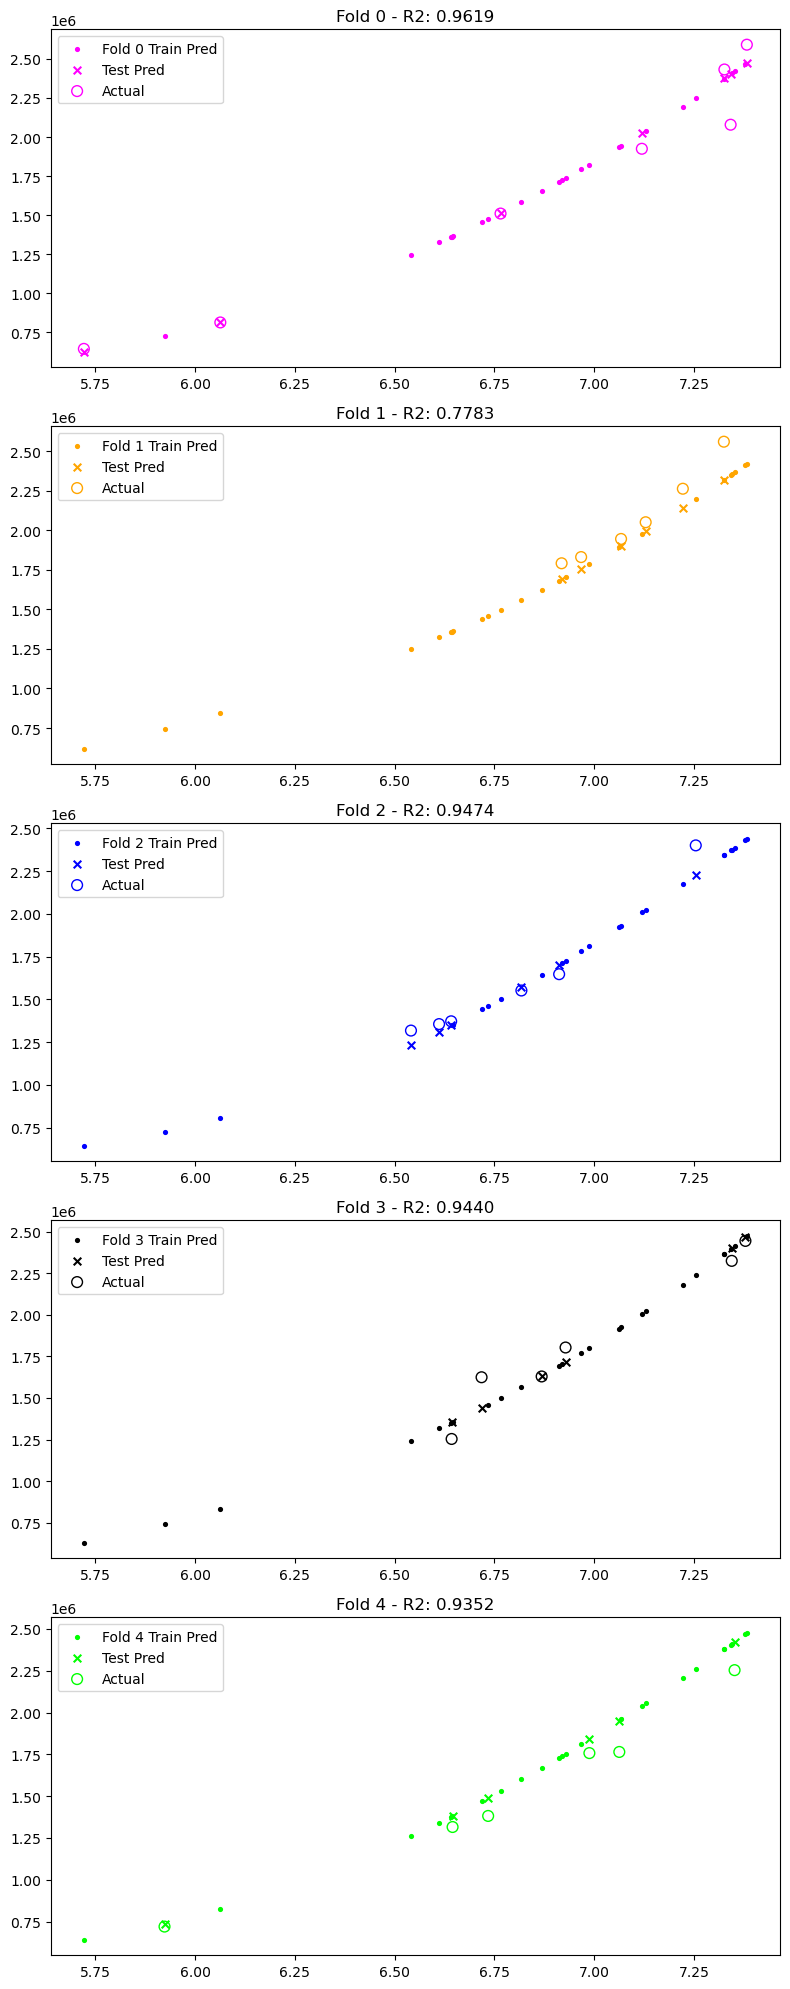

Average R2 Score: 0.9134
R2 Scores per fold: [0.9618763194098432, 0.7783394913013091, 0.9473962537244085, 0.9439505890694556, 0.935211923461607]


In [26]:
# Prepare Data (X can be multiple input colums)
# Example: X = df_train[["logperm", "porosity", "depth"]].values
# X = df_train[["logperm","acoustic_imp"]].values
X = df_train[["logperm"]].values 
y = df_train["cumulative_3y"].values

kf = KFold(n_splits=5, shuffle=True)
r2scores = []
cols = ["magenta", "orange", "blue", "black", "lime"]

fig, ax = plt.subplots(5, 1, figsize=(8, 20))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Define the Pipeline
    # Moving PolynomialFeatures inside the pipeline is cleaner for multi-variable X
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3, include_bias=True)),
        #('model', SVR(kernel='rbf', C=50, gamma=0.1)) # Adjust C and gamma as needed
        ('model', Lasso())
    ])
    
    # Split data 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit and Predict
    pipe.fit(X_train, y_train)
    ypred = pipe.predict(X_test)
    ytrainpreds = pipe.predict(X_train)

    # Visualization
    # Note: For plotting, we use X_train[:, 0] to represent the first feature on the x-axis
    ax[i].scatter(X_train[:, 0], ytrainpreds, color=cols[i], lw=1.5, label=f"Fold {i} Train Pred", s=5)
    ax[i].scatter(X_test[:, 0], ypred, marker="x", s=30, color=cols[i], label="Test Pred")
    ax[i].scatter(X_test[:, 0], y_test, marker="o", s=60, edgecolors=cols[i], facecolors='None', label="Actual")

    score = r2_score(y_test, ypred)
    r2scores.append(score)
    ax[i].set_title(f"Fold {i} - R2: {score:.4f}")
    ax[i].legend()

plt.tight_layout()
plt.show()

print(f"Average R2 Score: {sum(r2scores)/len(r2scores):.4f}")
print("R2 Scores per fold:", r2scores)

In [27]:
realizations_per_sample = {  }
for i in range(df_train.shape[0]):
    withold_point = df_train.iloc[i,:]
    x_wh = withold_point["logperm"].reshape(-1,1)
    y_hw = withold_point["cumulative_3y"]
    new_df      = pd.concat( [df_train.iloc[0:i,:],df_train.iloc[i+1:,:]] )
    X           = new_df["logperm"].values
    y           = new_df["cumulative_3y"].values
    realizations_per_sample[ i ] = { "actual":y_hw,"reals":[  ] }
    for j in range(100):
        degree_rand = np.random.randint( 3 )   
        model_type_rand =  0#np.random.randint( 0,4 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ),AdaBoostRegressor(  ),LinearRegression(  )]
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.80 )
        model = model_types[model_type_rand]
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        if model_type_rand<=1:
            poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features=poly.fit_transform(X_train.reshape(-1,1))
            poly_test=poly.transform( x_wh.reshape(-1,1) )
            pipe.fit(poly_features, y_train)
            # ypred = pipe.predict( poly_test )
            # ytrainpreds = pipe.predict( poly_features )
            ywhp = pipe.predict( poly_test )[0]
        else:
            pipe.fit(X_train.reshape(-1,1), y_train)
            ywhp = pipe.predict( x_wh )[0]
        
        
        realizations_per_sample[ i ]["reals"].append( ywhp )

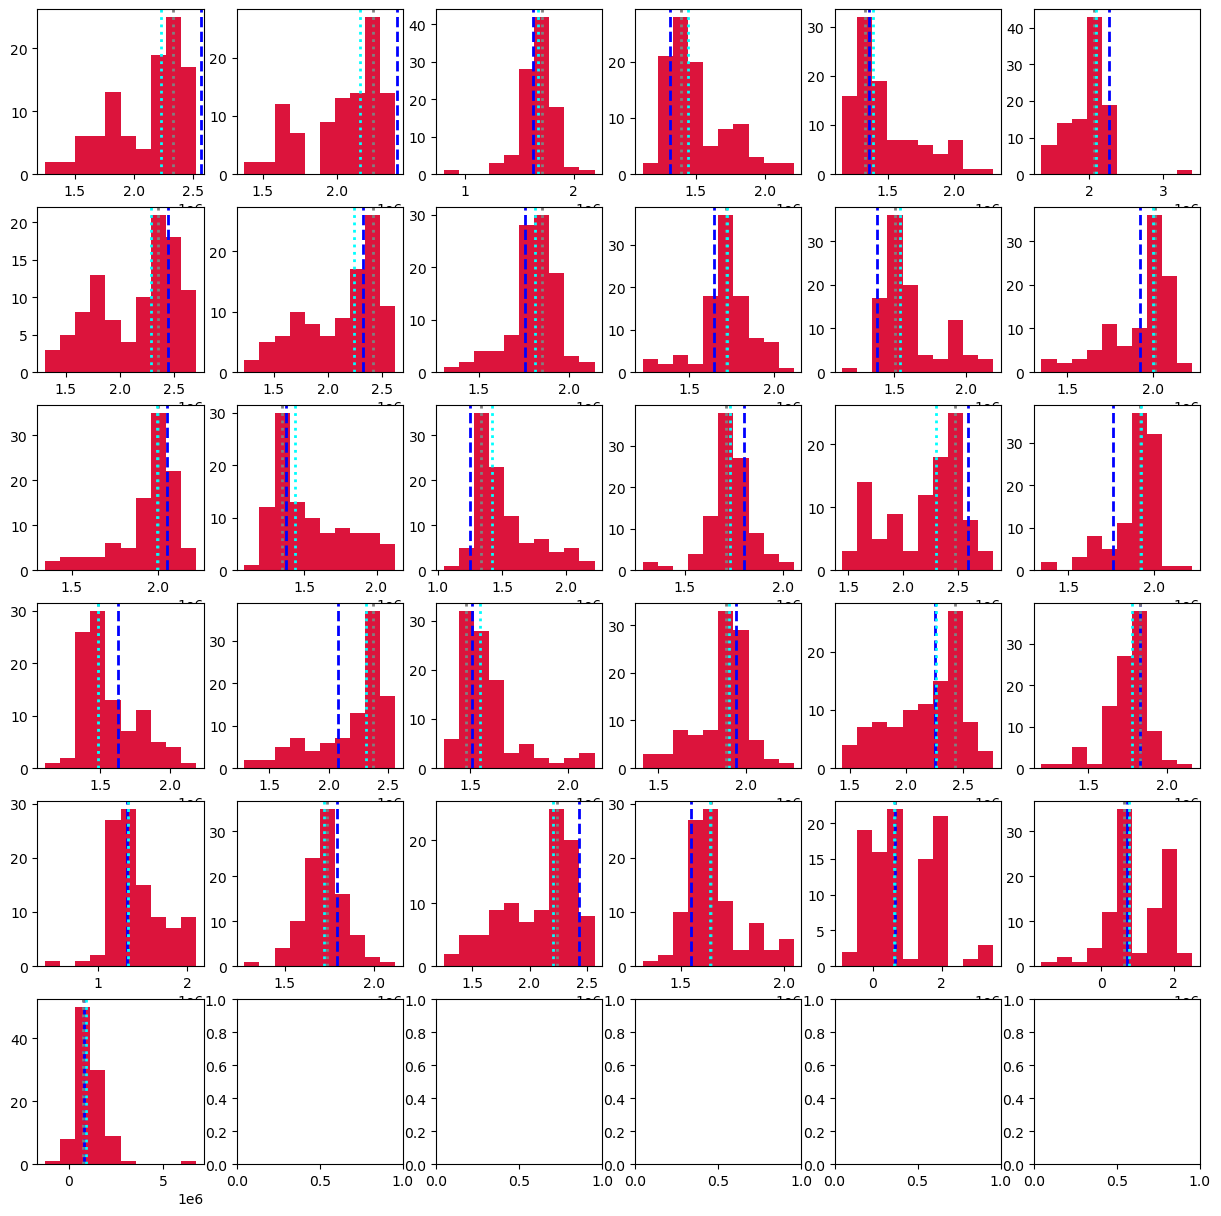

In [28]:
# Visualizing uncertainty estimates from multiple realizations
fig,axs = plt.subplots( 6,6,figsize=(15,15),facecolor="white" )
for k in range(df_train.shape[0]):
    row = k//6
    colm = k%6
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ k ]["reals"],color="crimson" )
    imax = np.argmax(counts)
    midpoint = 0.5 * (bin_edges[imax] + bin_edges[imax + 1])
    axs[row,colm].axvline( realizations_per_sample[ k ]["actual"],ls="--",lw=2.0,color="blue" )
    axs[row,colm].axvline( midpoint,ls="dotted",lw=2.0,color="gray" )
    axs[row,colm].axvline( np.median( realizations_per_sample[ k ]["reals"] ),ls="dotted",lw=2.0,color="cyan" )

## Uncertainty Model for inital linear regression

In [29]:
## Uncertainty Model
realizations_per_sample = {  }
for i in range(df_train.shape[0]):
    # Withholding one point at a time
    withold_point = df_train.iloc[i,:]
    x_wh = withold_point["logperm"].reshape(-1,1)
    y_hw = withold_point["cumulative_3y"]
    new_df      = pd.concat( [df_train.iloc[0:i,:],df_train.iloc[i+1:,:]] )
    X           = new_df["logperm"].values
    y           = new_df["cumulative_3y"].values
    realizations_per_sample[ i ] = { "actual":y_hw,"reals":[  ] }
    for j in range(100):
        degree_rand = np.random.randint( 3 )   
        model_type_rand =  0#np.random.randint( 0,4 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ), AdaBoostRegressor(  ),LinearRegression(  )]
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.80 )
        model = model_types[model_type_rand]
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        if model_type_rand<=1:
            poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features=poly.fit_transform(X_train.reshape(-1,1))
            poly_test=poly.transform( x_wh.reshape(-1,1) )
            pipe.fit(poly_features, y_train)
            # ypred = pipe.predict( poly_test )
            # ytrainpreds = pipe.predict( poly_features )
            ywhp = pipe.predict( poly_test )[0]
        else:
            pipe.fit(X_train.reshape(-1,1), y_train)
            ywhp = pipe.predict( x_wh )[0]
        
        
        realizations_per_sample[ i ]["reals"].append( ywhp )


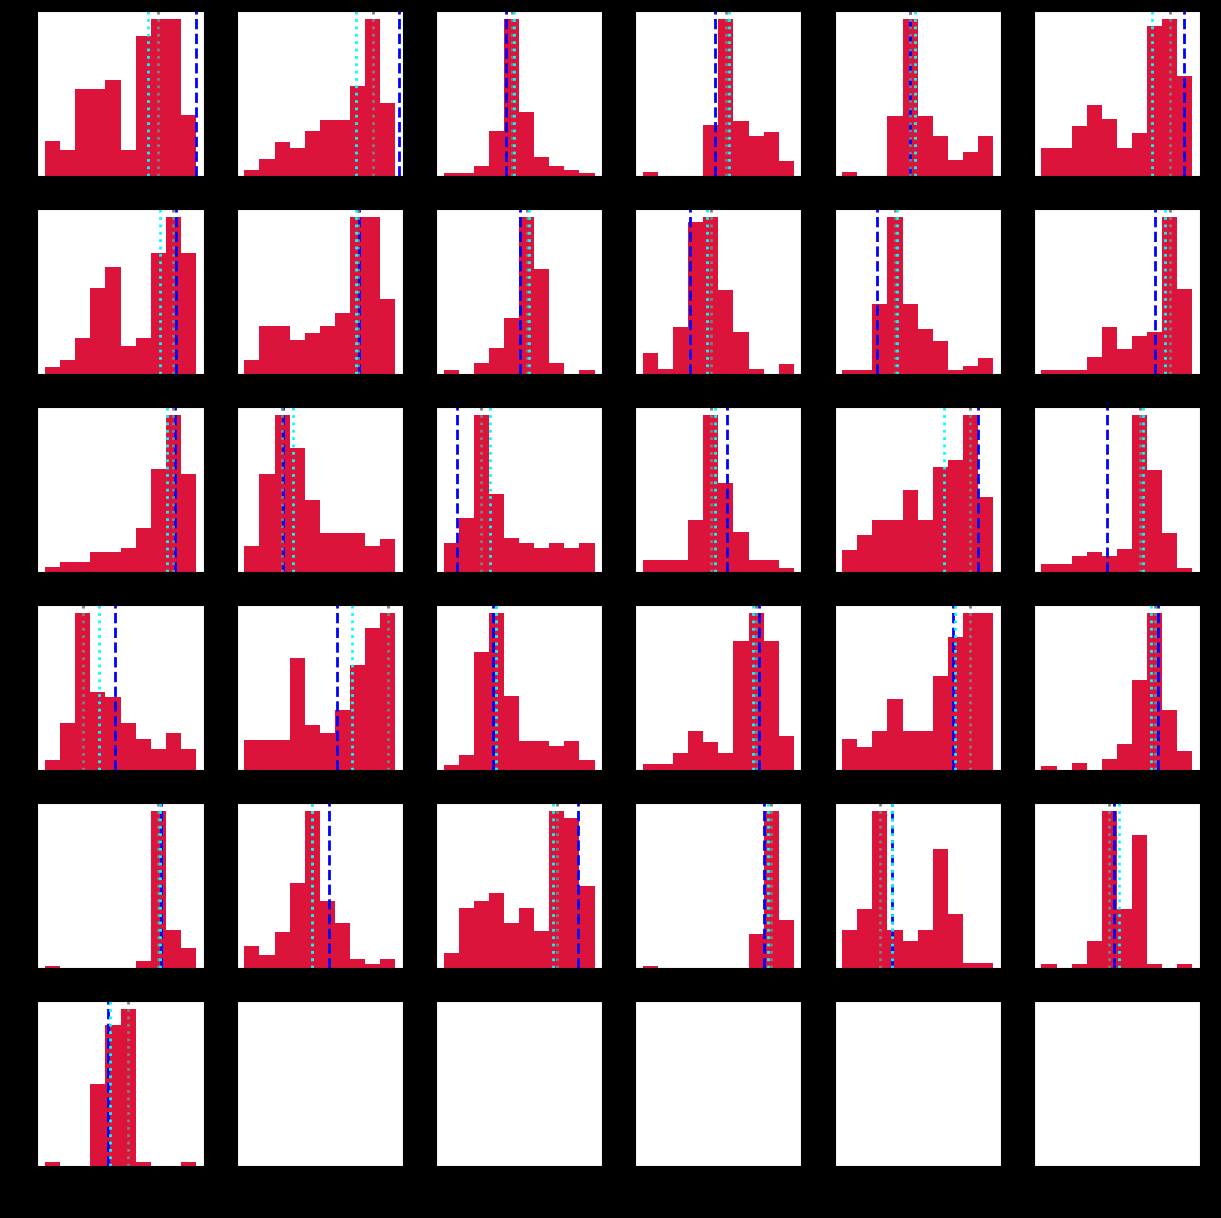

In [30]:
# Visulizing uncertainty estimates from multiple realizations
fig,axs = plt.subplots( 6,6,figsize=(15,15),facecolor="black" )
for k in range(df_train.shape[0]):
    row = k//6
    colm = k%6
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ k ]["reals"],color="crimson" )
    imax = np.argmax(counts)
    midpoint = 0.5 * (bin_edges[imax] + bin_edges[imax + 1])
    axs[row,colm].axvline( realizations_per_sample[ k ]["actual"],ls="--",lw=2.0,color="blue" )
    axs[row,colm].axvline( midpoint,ls="dotted",lw=2.0,color="gray" )
    axs[row,colm].axvline( np.median( realizations_per_sample[ k ]["reals"] ),ls="dotted",lw=2.0,color="cyan" )

In [31]:
# Calculating counts per bin for uncertainty distribution
counts = [ ]
for percent_value in np.arange(0,1.1,0.1):
    count = 0
    outside_range=1-percent_value
    for k in range(df_train.shape[0]):
        if (realizations_per_sample[ k ]["actual"]>=np.quantile( realizations_per_sample[ k ]["reals"],outside_range/2 )) and (realizations_per_sample[ k ]["actual"]<=np.quantile( realizations_per_sample[ k ]["reals"],1-outside_range/2 )):
            count += 1
    counts.append( count/df_train.shape[0] )
counts = np.array(counts)

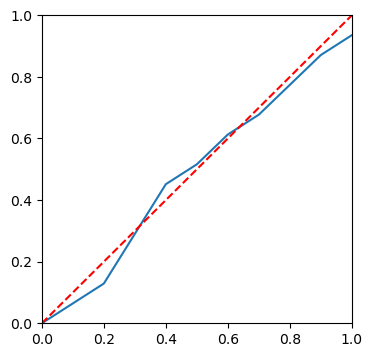

In [32]:
# Plotting the straight line reference for normal distribution
fig,ax = plt.subplots( figsize=(4,4) )
ax.plot( np.arange(0,1.1,0.1),counts )
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.add_line( Line2D( [0,1],[0,1],color="red",lw=1.5,ls="--" ) )

## Final predictions for simple linear regression model

In [33]:
# Preparing preproduction data for predictions
df_preproduction = pd.read_csv( "logs_preproduction.csv" )
df_preproduction["mean_perm"] = 0
for id in np.unique( df_preproduction["Well_ID"] ):
    print(np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] ))
    df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )
    df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_AI"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["AI"] )

614.5193707165
1078.506667467619
936.0280205089524
1636.2010318947366
846.6214038333334
683.7977429293501
122.65067313336843
427.9245321080952
137.19931909204763
374.93761647785
286.17728327500004
433.69381494095234


/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_23476/1267113493.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '614.5193707165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )


In [34]:
# Grouping pre-production data by well ID
df_preproduction_grouped = df_preproduction.groupby("Well_ID", as_index=False).first(  )

# Adding log of permeability as feature to predict
df_preproduction_grouped["logperm"] = np.log( df_preproduction_grouped["mean_perm"] )
df_preproduction_grouped.head(  )

Well_ID   X    Y   Z         AI           SI           Vp           Vs  \
0       72  23   94  19  7197904.5  2875019.500  2857.923584  1141.524780   
1       73  57  142  19  6787758.5  3335389.250  2781.488525  1366.776245   
2       74  80   61  19  8425695.0  3489587.250  3232.098633  1338.606445   
3       75  45  187  19  4282267.5  2015072.875  1945.088989   915.285278   
4       76  68  108  19  5828772.0  2514801.750  2473.237305  1072.350830   

      rho_b     rho_f  ...         G0      Gdry      Gsat  facies       phi  \
0  2.334913  1.073520  ...  13.098044  3.281906  3.281906     5.0  0.081892   
1  2.440333  0.977868  ...  25.536600  4.558731  4.558731     3.0  0.120740   
2  2.606881  1.077363  ...  13.592002  4.671184  4.671184     6.0  0.041320   
3  2.201579  0.909153  ...  42.125225  1.844367  1.809800     2.0  0.256617   
4  2.356738  1.029221  ...  21.961340  2.710099  2.710099     4.0  0.175637   

          perm         GR    mean_perm       mean_AI   logperm  
0    30.410023  87.724987   614.519371  5.229836e+06  6.420840  
1    98.241755  51.590473  1078.506667  4.480050e+06  6.983333  
2     3.886722  95.822611   936.028021  5.302339e+06  6.841645  
3  1040.215182  39.272246  1636.201032  3.950868e+06  7.400132  
4   307.481393  57.090879   846.621404  4.853555e+06  6.741254  

[5 rows x 25 columns]

In [35]:
# Making predictions with uncertainty estimates for preproduction data
realizations_per_sample = {  }
for i in range(df_preproduction_grouped.shape[0]):
    id = df_preproduction_grouped.iloc[i]["Well_ID"]
    Xinterest = df_preproduction_grouped.iloc[i]["logperm"]
    realizations_per_sample[ id ] = { "best_pred":0.0,"realizations":[  ] }
    for j in range(100):
        degree_rand = 3 #Tuned via resampling (see code above)
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.80 )
        model = LinearRegression(  ) #Selected via resampling (see code above)
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
        poly_features=poly.fit_transform(X_train.reshape(-1,1))
        poly_test=poly.transform( Xinterest.reshape(-1,1) )
        pipe.fit(poly_features, y_train)
        ypred = pipe.predict( poly_test )[0]            
        realizations_per_sample[ id ]["realizations"].append( ypred )
    realizations_per_sample[ id ]["best_pred"] = np.median( realizations_per_sample[ id ]["realizations"] )
    print( f"Best Prediction for Well {id} is: {realizations_per_sample[ id ]['best_pred']} BBL." )


print(realizations_per_sample)


Best Prediction for Well 72.0 is: 1089027.9204893224 BBL.
Best Prediction for Well 73.0 is: 1792375.5133492234 BBL.
Best Prediction for Well 74.0 is: 1609347.7230918019 BBL.
Best Prediction for Well 75.0 is: 2466089.1007542126 BBL.
Best Prediction for Well 76.0 is: 1470754.1192483446 BBL.
Best Prediction for Well 77.0 is: 1256921.418341922 BBL.
Best Prediction for Well 78.0 is: 1446041.3499937756 BBL.
Best Prediction for Well 79.0 is: 908232.3334383008 BBL.
Best Prediction for Well 80.0 is: 391447.4191718636 BBL.
Best Prediction for Well 81.0 is: 722542.4753632828 BBL.
Best Prediction for Well 82.0 is: 643097.3077318362 BBL.
Best Prediction for Well 83.0 is: 861381.2903644579 BBL.
{72.0: {'best_pred': 1089027.9204893224, 'realizations': [1425847.8899789313, 238594.6233014993, 1207752.7429300582, -2889037.3376861913, 302181.3060423841, 638297.5021959483, -560866.6534307618, 813978.0505637943, 2231155.0007282705, 881365.5189410164, 628189.5749373343, -4466223.9691061415, 1091221.50638157

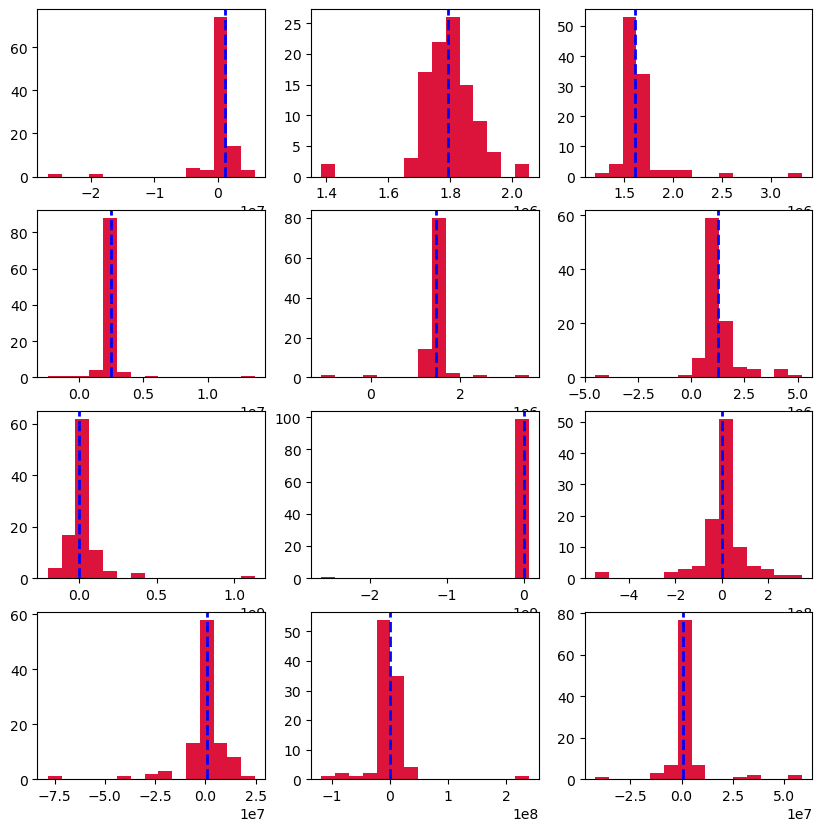

In [36]:
# Visualizing uncertainty estimates for pre-production data
fig,axs = plt.subplots( 4,3,figsize=(10,10),facecolor="white" )
for k in range(df_preproduction_grouped.shape[0]):
    row = k//3
    colm = k%3
    id = df_preproduction_grouped.iloc[k]["Well_ID"]
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ id ]["realizations"],color="crimson",bins=15 )
    axs[row,colm].axvline( realizations_per_sample[ id ]["best_pred"],ls="--",lw=2.0,color="blue" )

In [37]:
# Preparing final solution dataframe and saving to csv
df_solution = pd.read_csv( "solution.csv" )
for id in df_solution["Well_ID"].values:
    df_solution.loc[df_solution["Well_ID"]==id,"Prediction_BBL"] = realizations_per_sample[id]["best_pred"]
    df_solution.loc[df_solution["Well_ID"]==id, df_solution.columns[2:]] = realizations_per_sample[id]["realizations"]
df_solution.to_csv( "final_solution.csv",index=False )

## Testing our second model.
Including categorical value using acoustic impedance to define at which region of productivity our we located

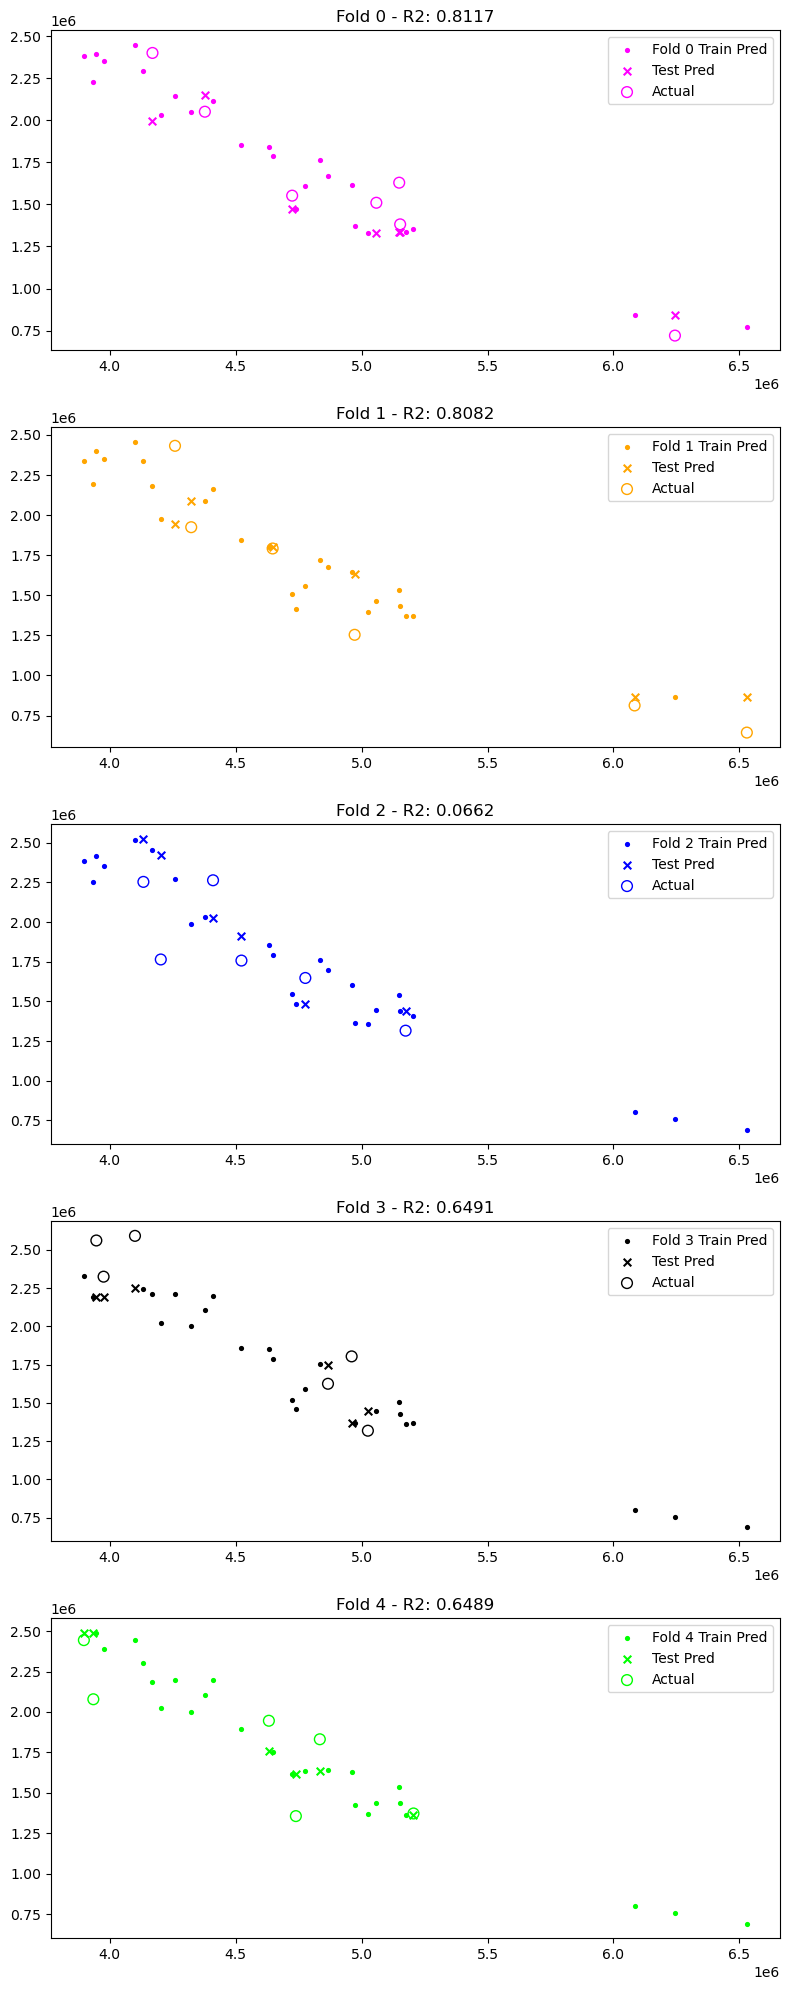

Average R2 Score: 0.5968
R2 Scores per fold: [0.8117414167396846, 0.808154977413792, 0.06621313801077944, 0.6490994002102535, 0.648852918885152]


In [38]:
# Prepare Data (X can be multiple input colums)
# Example: X = df_train[["logperm", "porosity", "depth"]].values
# X = df_train[["logperm","acoustic_imp"]].values
X = df_train[["acoustic_imp"]].values 
y = df_train["cumulative_3y"].values

kf = KFold(n_splits=5, shuffle=True)
r2scores = []
cols = ["magenta", "orange", "blue", "black", "lime"]

fig, ax = plt.subplots(5, 1, figsize=(8, 20))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Define the Pipeline
    # Moving PolynomialFeatures inside the pipeline is cleaner for multi-variable X
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        #('poly', PolynomialFeatures(degree=3, include_bias=True)),
        #('model', SVR(kernel='rbf', C=50, gamma=0.1)) # Adjust C and gamma as needed
        #('model', Lasso())
        #('model', DecisionTreeRegressor(max_depth=5, min_samples_split=10))
        ('model', RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42))
    ])
    
    # Split data 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit and Predict
    pipe.fit(X_train, y_train)
    ypred = pipe.predict(X_test)
    ytrainpreds = pipe.predict(X_train)

    # Visualization
    # Note: For plotting, we use X_train[:, 0] to represent the first feature on the x-axis
    ax[i].scatter(X_train[:, 0], ytrainpreds, color=cols[i], lw=1.5, label=f"Fold {i} Train Pred", s=5)
    ax[i].scatter(X_test[:, 0], ypred, marker="x", s=30, color=cols[i], label="Test Pred")
    ax[i].scatter(X_test[:, 0], y_test, marker="o", s=60, edgecolors=cols[i], facecolors='None', label="Actual")

    score = r2_score(y_test, ypred)
    r2scores.append(score)
    ax[i].set_title(f"Fold {i} - R2: {score:.4f}")
    ax[i].legend()

plt.tight_layout()
plt.show()

print(f"Average R2 Score: {sum(r2scores)/len(r2scores):.4f}")
print("R2 Scores per fold:", r2scores)

In [39]:
# Two-Stage Model with Uncertainty Estimation
realizations_per_sample = {}

for i in range(df_train.shape[0]):
    # Withhold one point at a time
    withhold_point = df_train.iloc[i,:]
    new_df = df_train.drop(df_train.index[i])
    
    # Target variable
    y_actual = withhold_point["cumulative_3y"]
    
    realizations_per_sample[i] = {"actual": y_actual, "reals": []}
    
    for j in range(100):
        degree_rand = np.random.randint( 3 )
        # Using percentage % to train the model
        train_sub, test_sub = train_test_split(new_df, test_size=0.70)
        
        # Decision tree model as first stage to predict cumulative production from acoustic impedance
        dt_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
        X_stage1_train = train_sub[["acoustic_imp"]].values
        y_stage1_train = train_sub["cumulative_3y"].values
        # Defining the pipeline for stage one
        pipe1 = Pipeline( [('scaler', StandardScaler(  )), ('model', dt_model)] )
        pipe1.fit(X_stage1_train, y_stage1_train)
        
        # stage one predictions to inform second state
        stage1_preds_train = pipe1.predict(X_stage1_train)
        stage1_pred_withheld = pipe1.predict(withhold_point[["acoustic_imp"]].values.reshape(1, -1))
        
        # Second stage, using the polynomial regression model
        # Data for second stage
        X_stage2_train = np.column_stack((stage1_preds_train, train_sub["logperm"].values))
        y_stage2_train = train_sub["cumulative_3y"].values # Predicting the true target
        # Features prediction form 1st model, and logperm
        lr_model = LinearRegression()
        # Defining polynomial
        poly_model=PolynomialFeatures(degree=degree_rand,include_bias=True)
        poly_features=poly_model.fit_transform(X_stage2_train)
        # Defining pipeline for stage two
        pipe2 = Pipeline( [('scaler', StandardScaler(  )), ('model', lr_model)] )
        # Fitting second stage model
        pipe2.fit(poly_features, y_stage2_train)
        
        # poly_model.fit(X_stage2_train, y_stage2_train)
        
        # Final Prediction for the withheld point
        X_stage2_withheld = np.array([[stage1_pred_withheld[0], withhold_point["logperm"]]])
        poly_test=poly_model.transform(X_stage2_withheld)
        final_pred = pipe2.predict(poly_test)[0]
        
        realizations_per_sample[i]["reals"].append(final_pred)

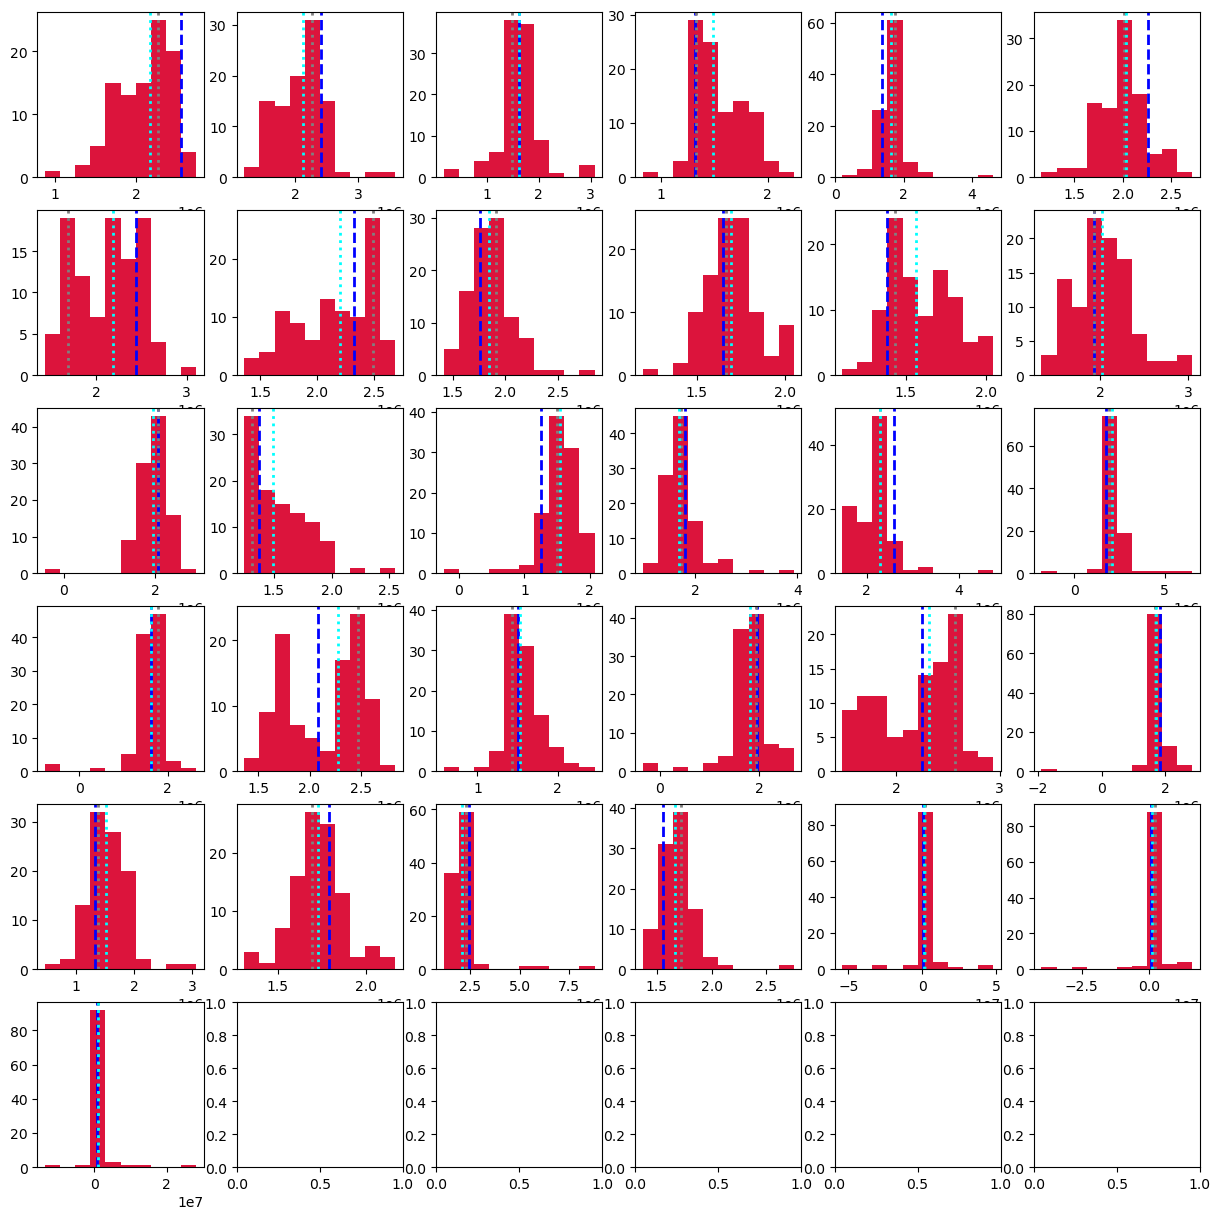

In [40]:
# Visulizing uncertainty estimates from multiple realizations
fig,axs = plt.subplots( 6,6,figsize=(15,15),facecolor="white" )
for k in range(df_train.shape[0]):
    row = k//6
    colm = k%6
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ k ]["reals"],color="crimson" )
    imax = np.argmax(counts)
    midpoint = 0.5 * (bin_edges[imax] + bin_edges[imax + 1])
    axs[row,colm].axvline( realizations_per_sample[ k ]["actual"],ls="--",lw=2.0,color="blue" )
    axs[row,colm].axvline( midpoint,ls="dotted",lw=2.0,color="gray" )
    axs[row,colm].axvline( np.median( realizations_per_sample[ k ]["reals"] ),ls="dotted",lw=2.0,color="cyan" )

In [41]:
counts = [ ]
for percent_value in np.arange(0,1.1,0.1):
    count = 0
    outside_range=1-percent_value
    for k in range(df_train.shape[0]):
        if (realizations_per_sample[ k ]["actual"]>=np.quantile( realizations_per_sample[ k ]["reals"],outside_range/2 )) and (realizations_per_sample[ k ]["actual"]<=np.quantile( realizations_per_sample[ k ]["reals"],1-outside_range/2 )):
            count += 1
    counts.append( count/df_train.shape[0] )
counts = np.array(counts)

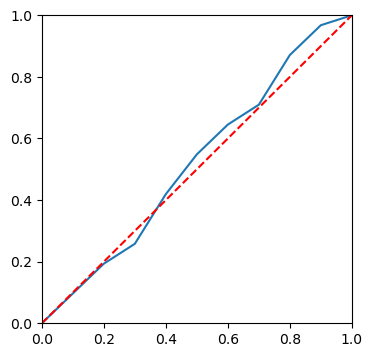

In [42]:
fig,ax = plt.subplots( figsize=(4,4) )
ax.plot( np.arange(0,1.1,0.1),counts )
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.add_line( Line2D( [0,1],[0,1],color="red",lw=1.5,ls="--" ) )

In [43]:
# Predicting with the two steps model for preproduction data
realizations_per_sample = {}

for i in range(df_preproduction_grouped.shape[0]):
    # Identify the well and its inputs
    well_row = df_preproduction_grouped.iloc[i]
    well_id = well_row["Well_ID"]
    
    # Preproduction inputs
    X_well_stage1 = well_row["mean_AI"]
    X_well_logperm = well_row["logperm"]
    
    realizations_per_sample[well_id] = {"best_pred": 0.0, "realizations": []}
    
    for j in range(100):
        degree_rand = 3 #Tuned via resampling (see code above)
        # As done previously, randomly sample training data
        #X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.70 )
        train_sub, _ = train_test_split(df_train, test_size=0.70)
        X_s1_train = train_sub[["acoustic_imp"]].values
        y_s1_train = train_sub["cumulative_3y"].values
        
        # from stage 1 using rando forest
        rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
        # Defining the pipeline for stage one
        pipe1 = Pipeline( [('scaler', StandardScaler(  )), ('model', rf_model)] )
        pipe1.fit(X_s1_train, y_s1_train)
               
        # Get predictions from Stage 1 to inform Stage 2
        s1_preds_train = pipe1.predict(X_s1_train)
        s1_pred_well = pipe1.predict(np.array([[X_well_stage1]]))
        
        # Using stage 2 with linear regression and polynomial
        # Features prediction form 1st model, and logperm
        lr_model = LinearRegression()
        # Defining polynomial
        poly_model=PolynomialFeatures(degree=degree_rand,include_bias=True)
        poly_features=poly_model.fit_transform(X_stage2_train)
        # Defining pipeline for stage two
        pipe2 = Pipeline( [('scaler', StandardScaler(  )), ('model', lr_model)] )
        
        X_s2_train = np.column_stack((s1_preds_train, train_sub["logperm"].values))
        y_s2_train = train_sub["cumulative_3y"].values
        
        pipe2.fit(X_s2_train, y_s2_train)
        
        # Final predicition for the new wells
        # Combine the Stage 1 result for the new well with its logperm
        X_s2_well = np.array([[s1_pred_well[0], X_well_logperm]])
        final_pred = pipe2.predict(X_s2_well)[0]
        
        realizations_per_sample[well_id]["realizations"].append(final_pred)
        
    # Calculate the median for the "best prediction"
    realizations_per_sample[well_id]["best_pred"] = np.median(realizations_per_sample[well_id]["realizations"])
    print( f"Best Prediction for Well {well_id} is: {realizations_per_sample[ well_id ]['best_pred']} BBL." )

print(realizations_per_sample)

Best Prediction for Well 72.0 is: 1291285.1329280145 BBL.
Best Prediction for Well 73.0 is: 1888265.6479615811 BBL.
Best Prediction for Well 74.0 is: 1458287.6879033623 BBL.
Best Prediction for Well 75.0 is: 2440612.0909180115 BBL.
Best Prediction for Well 76.0 is: 1562906.5713015383 BBL.
Best Prediction for Well 77.0 is: 1332723.153994624 BBL.
Best Prediction for Well 78.0 is: 321340.7600853635 BBL.
Best Prediction for Well 79.0 is: 792264.2028145206 BBL.
Best Prediction for Well 80.0 is: 347738.0348627968 BBL.
Best Prediction for Well 81.0 is: 694856.7498800061 BBL.
Best Prediction for Well 82.0 is: 636723.2371871118 BBL.
Best Prediction for Well 83.0 is: 781639.0470324329 BBL.
{72.0: {'best_pred': 1291285.1329280145, 'realizations': [1384831.2216278315, 1417464.4575700318, 1247070.8928835029, 1037368.6640815111, 1172635.084739781, 1241125.129981128, 1317716.8005275906, 1221669.4331868296, 1227945.0632597888, 1311636.761027998, 1356218.2413405972, 1290948.4598073487, 1342089.71443597

In [44]:
# Extract from realizations_per_sample the best predictions for each well and put them on a new csv file
df_solution_two_stage = pd.read_csv( "solution_before.csv" )
for id in df_solution_two_stage["Well_ID"].values:
    df_solution_two_stage.loc[df_solution_two_stage["Well_ID"]==id,"Prediction_BBL"] = realizations_per_sample[id]["best_pred"]
    df_solution_two_stage.loc[df_solution_two_stage["Well_ID"]==id, df_solution_two_stage.columns[2:]] = realizations_per_sample[id]["realizations"]
df_solution_two_stage.to_csv( "solution.csv",index=False)


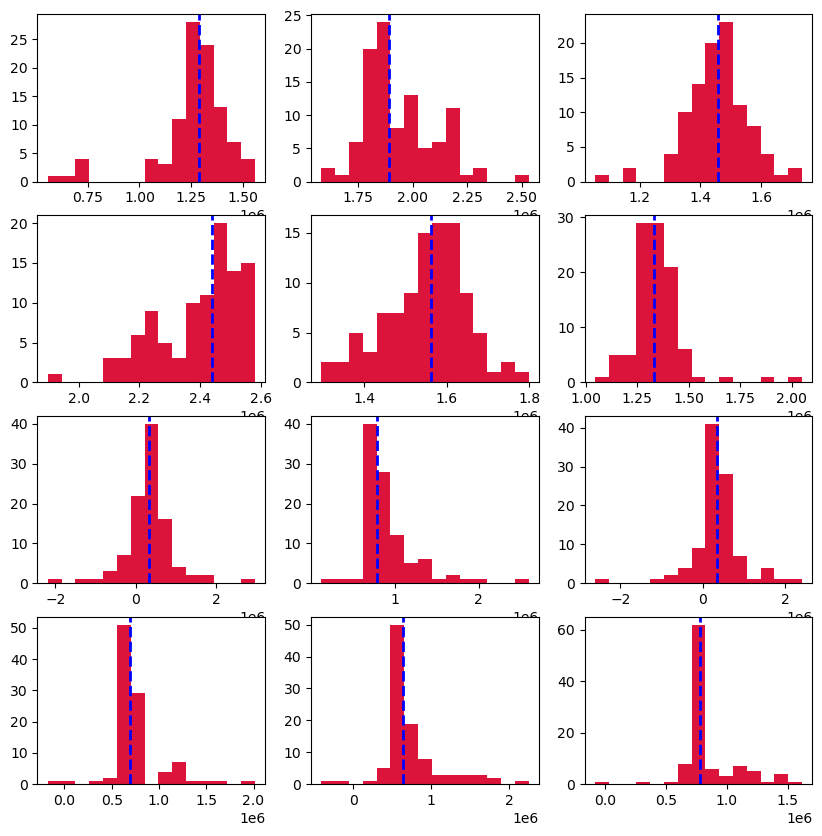

In [45]:
# Visualizing uncertainty estimates for pre-production data
fig,axs = plt.subplots( 4,3,figsize=(10,10),facecolor="white" )
for k in range(df_preproduction_grouped.shape[0]):
    row = k//3
    colm = k%3
    id = df_preproduction_grouped.iloc[k]["Well_ID"]
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ id ]["realizations"],color="crimson",bins=15 )
    axs[row,colm].axvline( realizations_per_sample[ id ]["best_pred"],ls="--",lw=2.0,color="blue" )